<p style="font-size:36px;text-align:center"> <b>Santander Customer Transaction Prediction</b> </p>

<p style="font-size:36px;text-align:center"> <img src="./image.jpg"> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<p> Source: https://www.kaggle.com/c/santander-customer-transaction-prediction </p>
<h6> Problem statement : </h6>
<p> Based on an anonymized dataset containing numeric feature variables, the binary target column, and a string ID_code column, the task is to predict the value of target column in the test set. </p>

<h2>1.2. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

- Source: https://www.kaggle.com/c/santander-customer-transaction-prediction/data


- The link above contains two csv files that are important for this analysis and prediction task, one of these files, train.csv is the training data, it contains a binary target column, a string ID_code and 200 numerical features that must be taken into consideration during the prediction task. The next csv file, test.csv is the test set which is not provided with target column and we must only use the bare numreical feature to complete this task

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    
            There are two different classes thus this task can said to of the type => binary class classification problem
   
      
    
</p>

<h3>2.2.2. Performance Metric</h3>

Source: https://www.kaggle.com/c/santander-customer-transaction-prediction/overview/evaluation

Metric:
* Area under the ROC curve

<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict if a transaction will happen based on the given 200 numerical features.
</p>
<p> Constraints:
</p>
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Area under the ROC curve.
* No Latency constraints.

<h1>3. Exploratory Data Analysis</h1>

<h3>3.1 Importing the required libraries</h3>

In [0]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import cross_val_predict
from tqdm import tqdm
from scipy.stats import norm, rankdata
from scipy.special import erfc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, fbeta_score, confusion_matrix, classification_report, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
import gplearn
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.functions import make_function
from gplearn.fitness import make_fitness
from prettytable import PrettyTable
warnings.filterwarnings('ignore')

<h3>3.2 Converting the downloaded csv files to Pandas Dataframe</h3>

In [26]:
start=time.time()
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
print ('Time taken for loading the dataset is {} minutes\n'.format((int(time.time()-start)/60)))

Time taken for loading the dataset is 0.18333333333333332 minutes



<h3>3.3 Getting acquainted with the structure of the dataset</h3>

In [0]:
print(train_df.shape)
print(test_df.shape)

(200000, 202)
(200000, 201)


#### Both train and test data have 200,000 entries and 202, respectivelly 201 columns.

#### Let's glimpse train and test dataset.

In [0]:
train_df.head()

ID_code  target    var_0   var_1  ...  var_196  var_197  var_198  var_199
0  train_0       0   8.9255 -6.7863  ...   7.8784   8.5635  12.7803  -1.0914
1  train_1       0  11.5006 -4.1473  ...   8.1267   8.7889  18.3560   1.9518
2  train_2       0   8.6093 -2.7457  ...  -6.5213   8.2675  14.7222   0.3965
3  train_3       0  11.0604 -2.1518  ...  -2.9275  10.2922  17.9697  -8.9996
4  train_4       0   9.8369 -1.4834  ...   3.9267   9.5031  17.9974  -8.8104

[5 rows x 202 columns]

In [0]:
test_df.head()

ID_code    var_0    var_1    var_2  ...  var_196  var_197  var_198  var_199
0  test_0  11.0656   7.7798  12.9536  ...   4.3654  10.7200  15.4722  -8.7197
1  test_1   8.5304   1.2543  11.3047  ...  -1.4852   9.8714  19.1293 -20.9760
2  test_2   5.4827 -10.3581  10.1407  ...  -7.1086   7.0618  19.8956 -23.1794
3  test_3   8.5374  -1.3222  12.0220  ...   3.9567   9.2295  13.0168  -4.2108
4  test_4  11.7058  -0.1327  14.1295  ...  -5.1612   7.2882  13.9260  -9.1846

[5 rows x 201 columns]

<p> Train contains:
</p>
* <b> ID_code </b>(string)
* <b> target </b>(int 0 & 1)
* <b> 200 </b>numerical float variables, named from <b>var_0 </b>to <b>var_199</b>

<p> Test contains:
</p>
* <b> ID_code </b>(string)
* <b> 200 </b>numerical float variables, named from <b>var_0 </b>to <b>var_199</b>

<h3>3.4 Finding if there is any sort of missing data in the dataset</h3>

In [0]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

<h4>3.4.1 First checking for the train dataset</h4>

In [0]:
missing_data(train_df)


ID_code target    var_0    var_1  ...  var_196  var_197  var_198  var_199
Total         0      0        0        0  ...        0        0        0        0
Percent       0      0        0        0  ...        0        0        0        0
Types    object  int64  float64  float64  ...  float64  float64  float64  float64

[3 rows x 202 columns]

#### From above result we can see that there isn't any missing data in the train dataset.

<h4>3.4.2 Now checking for the test dataset

In [0]:
missing_data(test_df)


ID_code    var_0    var_1    var_2  ...  var_196  var_197  var_198  var_199
Total         0        0        0        0  ...        0        0        0        0
Percent       0        0        0        0  ...        0        0        0        0
Types    object  float64  float64  float64  ...  float64  float64  float64  float64

[3 rows x 201 columns]

#### From above result we can see that there isn't any missing data in the test dataset either.

<h3> 3.5. Outlier Detection </h3>

- The technique used in this case study for outlier detection is 'chavenet criterion' more information regarding it can be found at 'https://en.wikipedia.org/wiki/Chauvenet%27s_criterion'

In [0]:
def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = erfc(d)                # Area normal dist.    
    return prob < criterion       # Use boolean array outside this function

In [0]:
numerical_features=train_df.columns[2:]

100%|██████████| 200/200 [00:01<00:00, 152.69it/s]


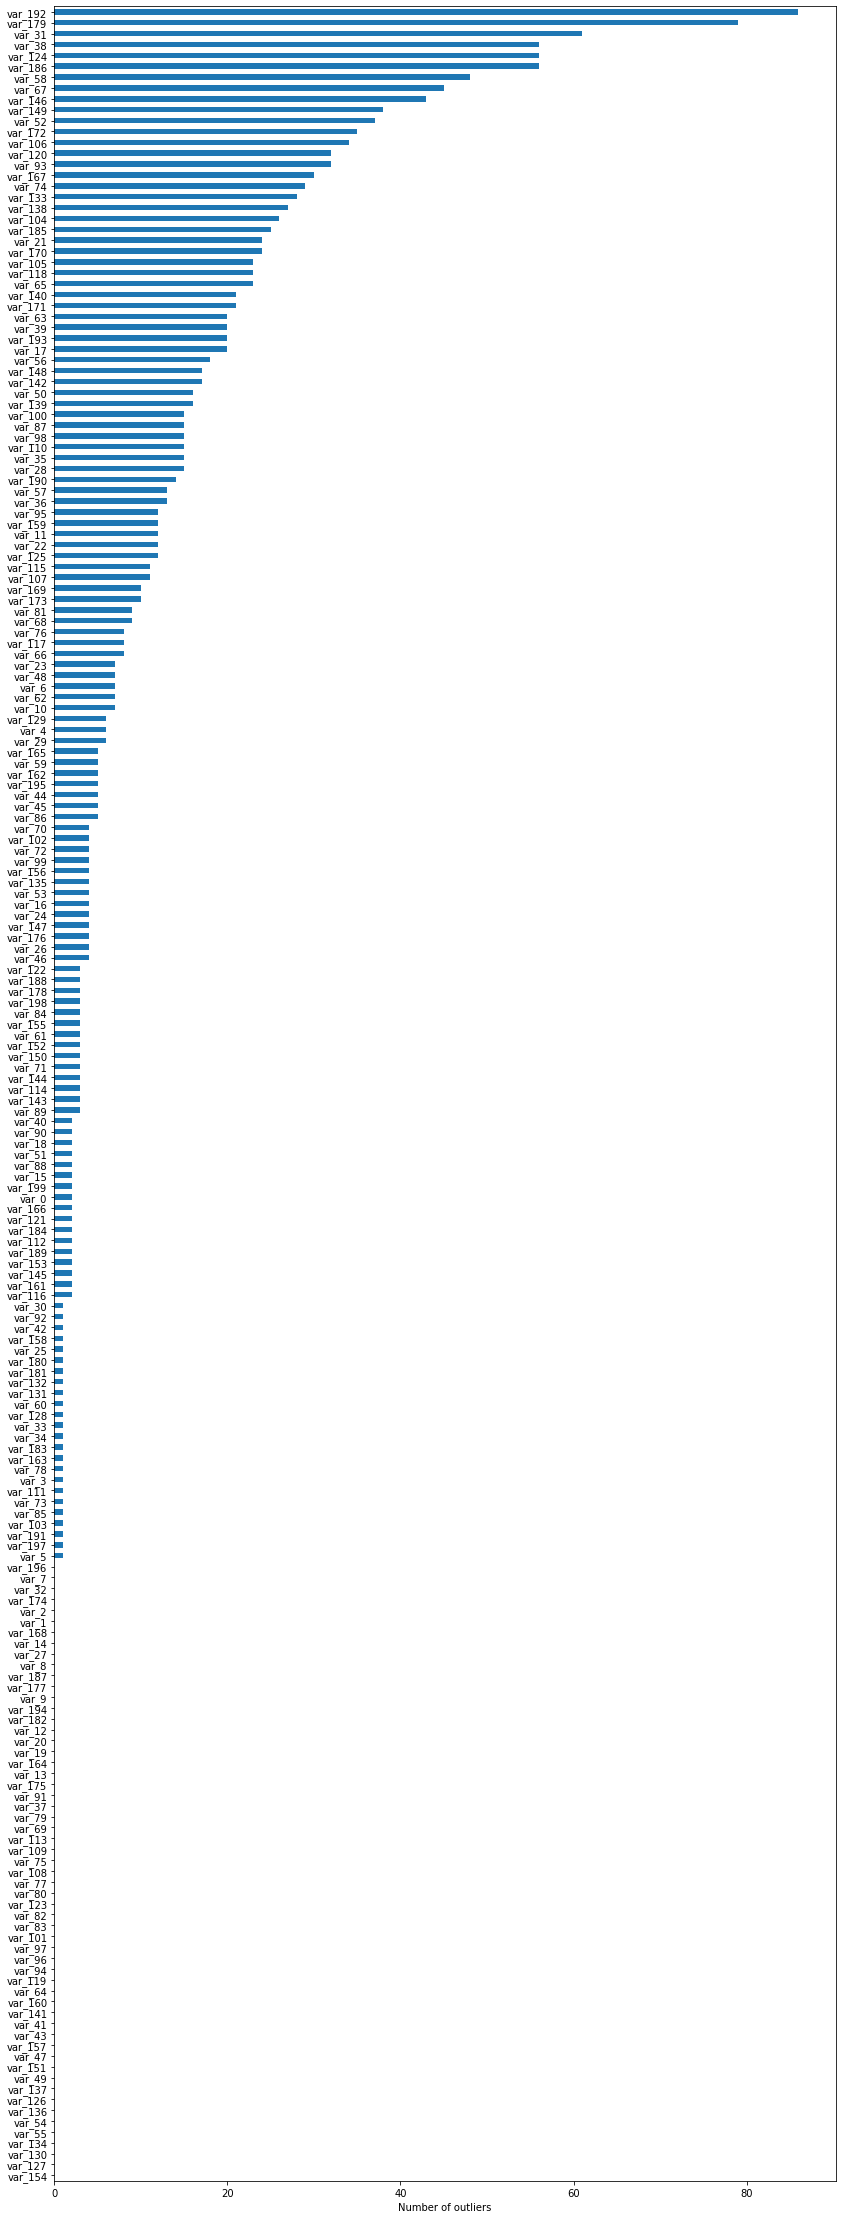

In [29]:
train_outliers = dict()
for col in tqdm([col for col in numerical_features]):
    train_outliers[col] = train_df[chauvenet(train_df[col].values)].shape[0]
train_outliers = pd.Series(train_outliers)

train_outliers.sort_values().plot(figsize=(14, 40), kind='barh').set_xlabel('Number of outliers');

In [30]:
print('Total number of outliers in training set: {} ({:.2f}%)'.format(sum(train_outliers.values), (sum(train_outliers.values) / train_df.shape[0]) * 100))

Total number of outliers in training set: 1740 (0.87%)


100%|██████████| 200/200 [00:01<00:00, 159.49it/s]


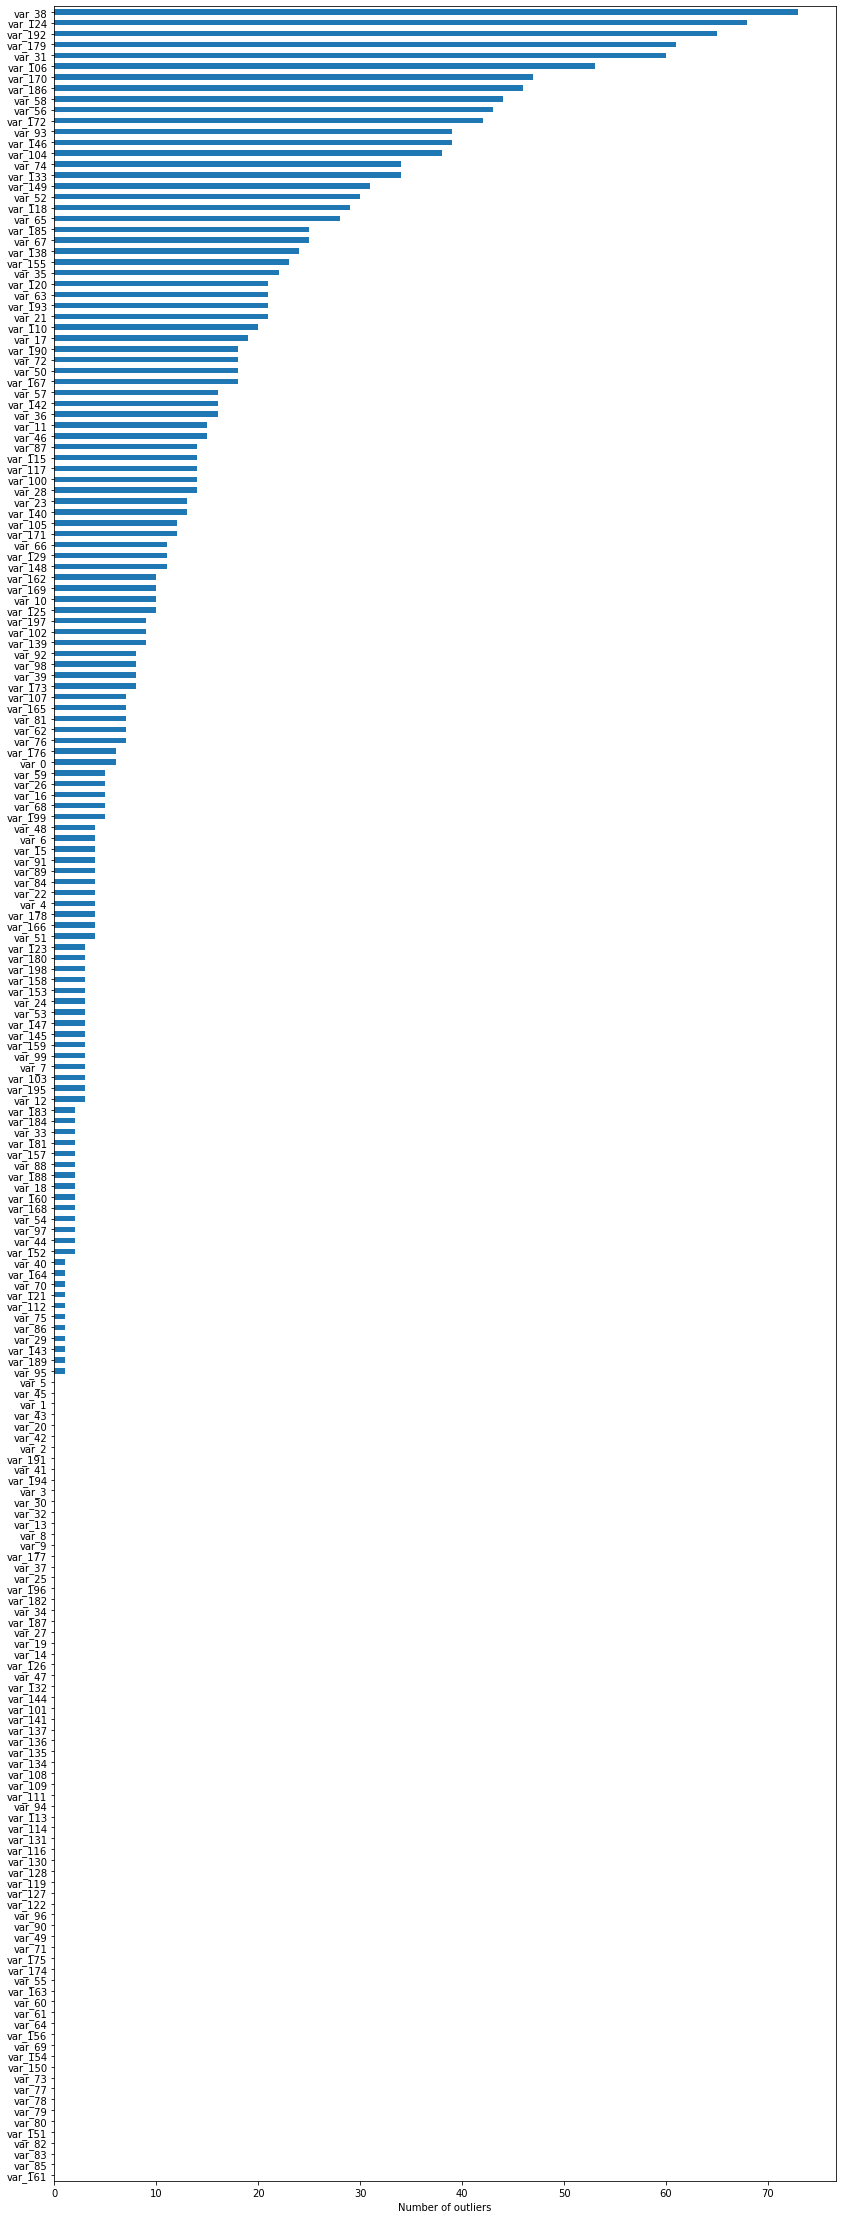

In [31]:
#outliers in each variable in test data 
test_outliers = dict()
for col in tqdm([col for col in numerical_features]):
    test_outliers[col] = test_df[chauvenet(test_df[col].values)].shape[0]
test_outliers = pd.Series(test_outliers)

test_outliers.sort_values().plot(figsize=(14, 40), kind='barh').set_xlabel('Number of outliers');

In [32]:
print('Total number of outliers in testing set: {} ({:.2f}%)'.format(sum(test_outliers.values), (sum(test_outliers.values) / test_df.shape[0]) * 100))

Total number of outliers in testing set: 1748 (0.87%)


In [33]:
#remove these outliers in train and test data
for col in tqdm(numerical_features):
    train_df=train_df.loc[(~chauvenet(train_df[col].values))]
for col in tqdm(numerical_features):
    test_df=test_df.loc[(~chauvenet(test_df[col].values))]

100%|██████████| 200/200 [00:19<00:00, 10.40it/s]


In [34]:

#shape of train and test data after removal of outliers 
train_df.shape, test_df.shape

((198264, 202), (198250, 201))

<h3> 3.6 Checking the numerical values in train and test dataset </h3>

In [0]:
train_df.describe()


target          var_0  ...        var_198        var_199
count  198264.000000  198264.000000  ...  198264.000000  198264.000000
mean        0.100412      10.679648  ...      15.871506      -3.326076
std         0.300549       3.039746  ...       3.010625      10.437785
min         0.000000       0.597900  ...       6.299300     -37.696200
25%         0.000000       8.454175  ...      13.829875     -11.207900
50%         0.000000      10.524200  ...      15.935700      -2.822200
75%         0.000000      12.758200  ...      18.065800       4.836800
max         1.000000      20.315000  ...      25.857100      28.500700

[8 rows x 201 columns]

In [0]:
test_df.describe()


var_0          var_1  ...        var_198        var_199
count  198250.000000  198250.000000  ...  198250.000000  198250.000000
mean       10.658132      -1.623584  ...      15.868352      -3.244830
std         3.036247       4.040598  ...       3.008109      10.395702
min         0.922000     -15.043400  ...       6.584000     -36.325100
25%         8.441800      -4.699350  ...      13.845900     -11.121975
50%        10.514200      -1.589400  ...      15.942700      -2.725950
75%        12.739600       1.343900  ...      18.044800       4.935700
max        20.064900       9.385100  ...      25.463400      27.907400

[8 rows x 200 columns]

<h4> 3.6.1We can make few observations here: </h4>
* standard deviation is relatively large for both train and test variable data
* min, max, mean values for train and test data looks quite close
* mean values are distributed over a large range.

<h3> 3.7 Checking the distribution of <b>target</b> value in train dataset.</h3>

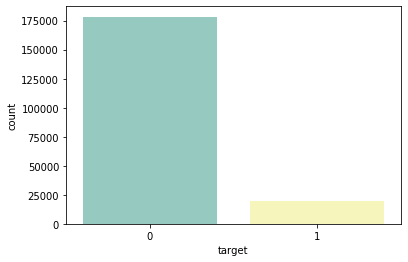

In [0]:
sns.countplot(train_df['target'], palette='Set3')


In [0]:
print("There are {}% target values with 0".format(100 * train_df["target"].value_counts()[0]/train_df.shape[0]))
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 89.95884275511439% target values with 0
There are 10.041157244885607% target values with 1


- From the above plot and the result we can see that the dataset is heavily imbalanced with approximately only one out of every ten datapoints having a target value '1'.</h4>

<h3> 3.8 Histogram of every column in train dataset</h3>

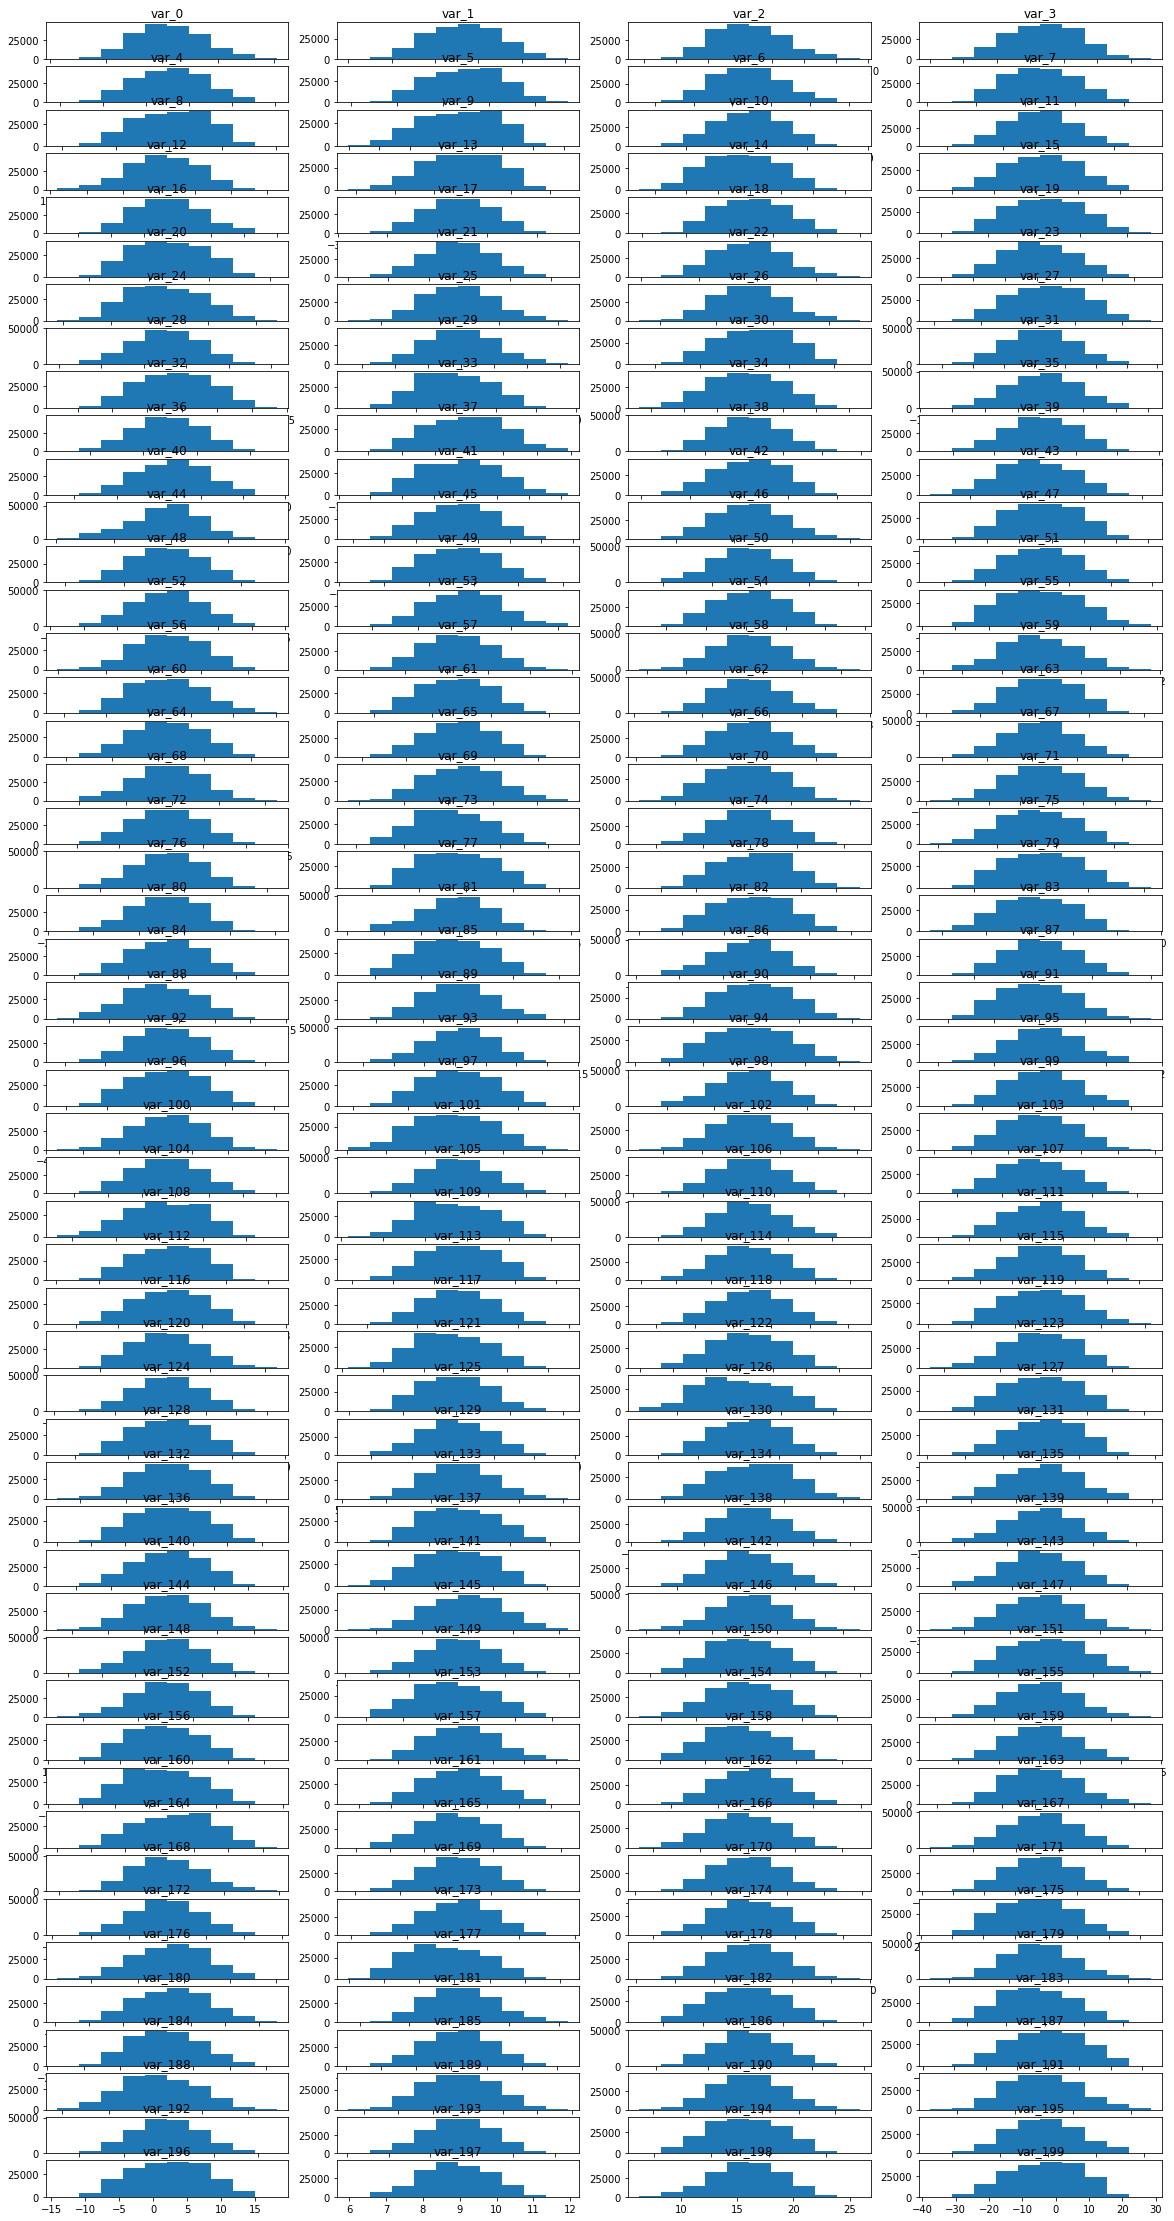

In [0]:
numerical_features=train_df.columns[2:]
plt.figure(figsize=(20, 40))
plt.title('Distribution of column')
for i,col in enumerate(numerical_features):
    plt.subplot(50,4,i+1)
    plt.hist(train_df[col])
    plt.title(col)

- We can observe from the above plots that every feature follows normal distribution.

<h3>3.8.1 Distribution of columns per target class in train dataset</h3>

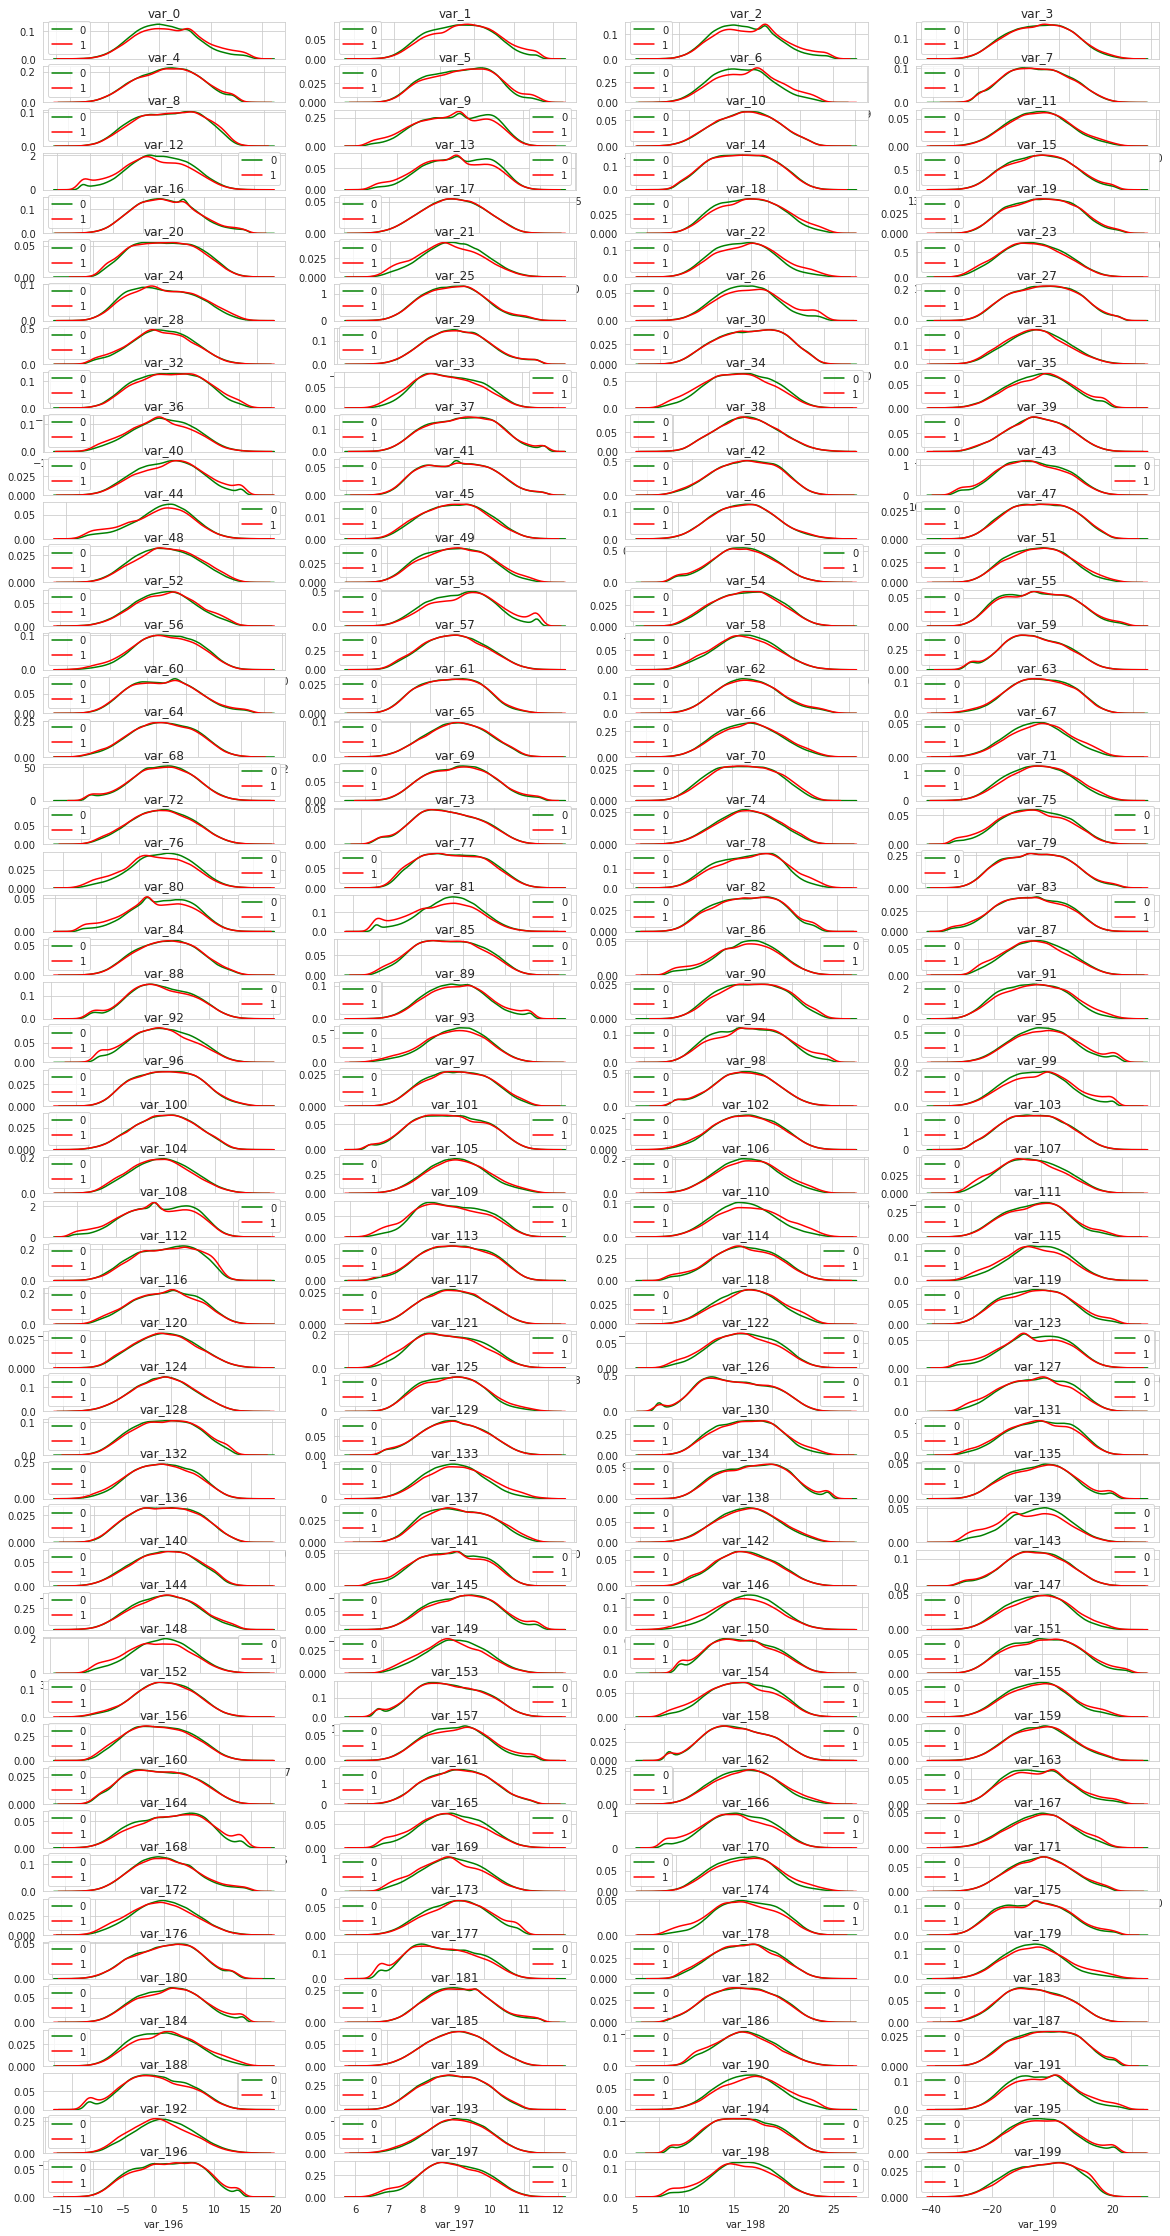

In [0]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 40))
for i,col in enumerate(numerical_features):
    plt.subplot(50,4,i+1)
    sns.distplot(train_df[train_df['target']==0][col],hist=False,label='0',color='green')
    sns.distplot(train_df[train_df['target']==1][col],hist=False,label='1',color='red')
    plt.title(col)

- From the above plots it can be observed that the plots for target '0' and target '1' overlap for each column except for a few features like var_40, var148, var_190, var_191, etc

<h3> 3.9 Distribution of columns for test and train datset </h3>

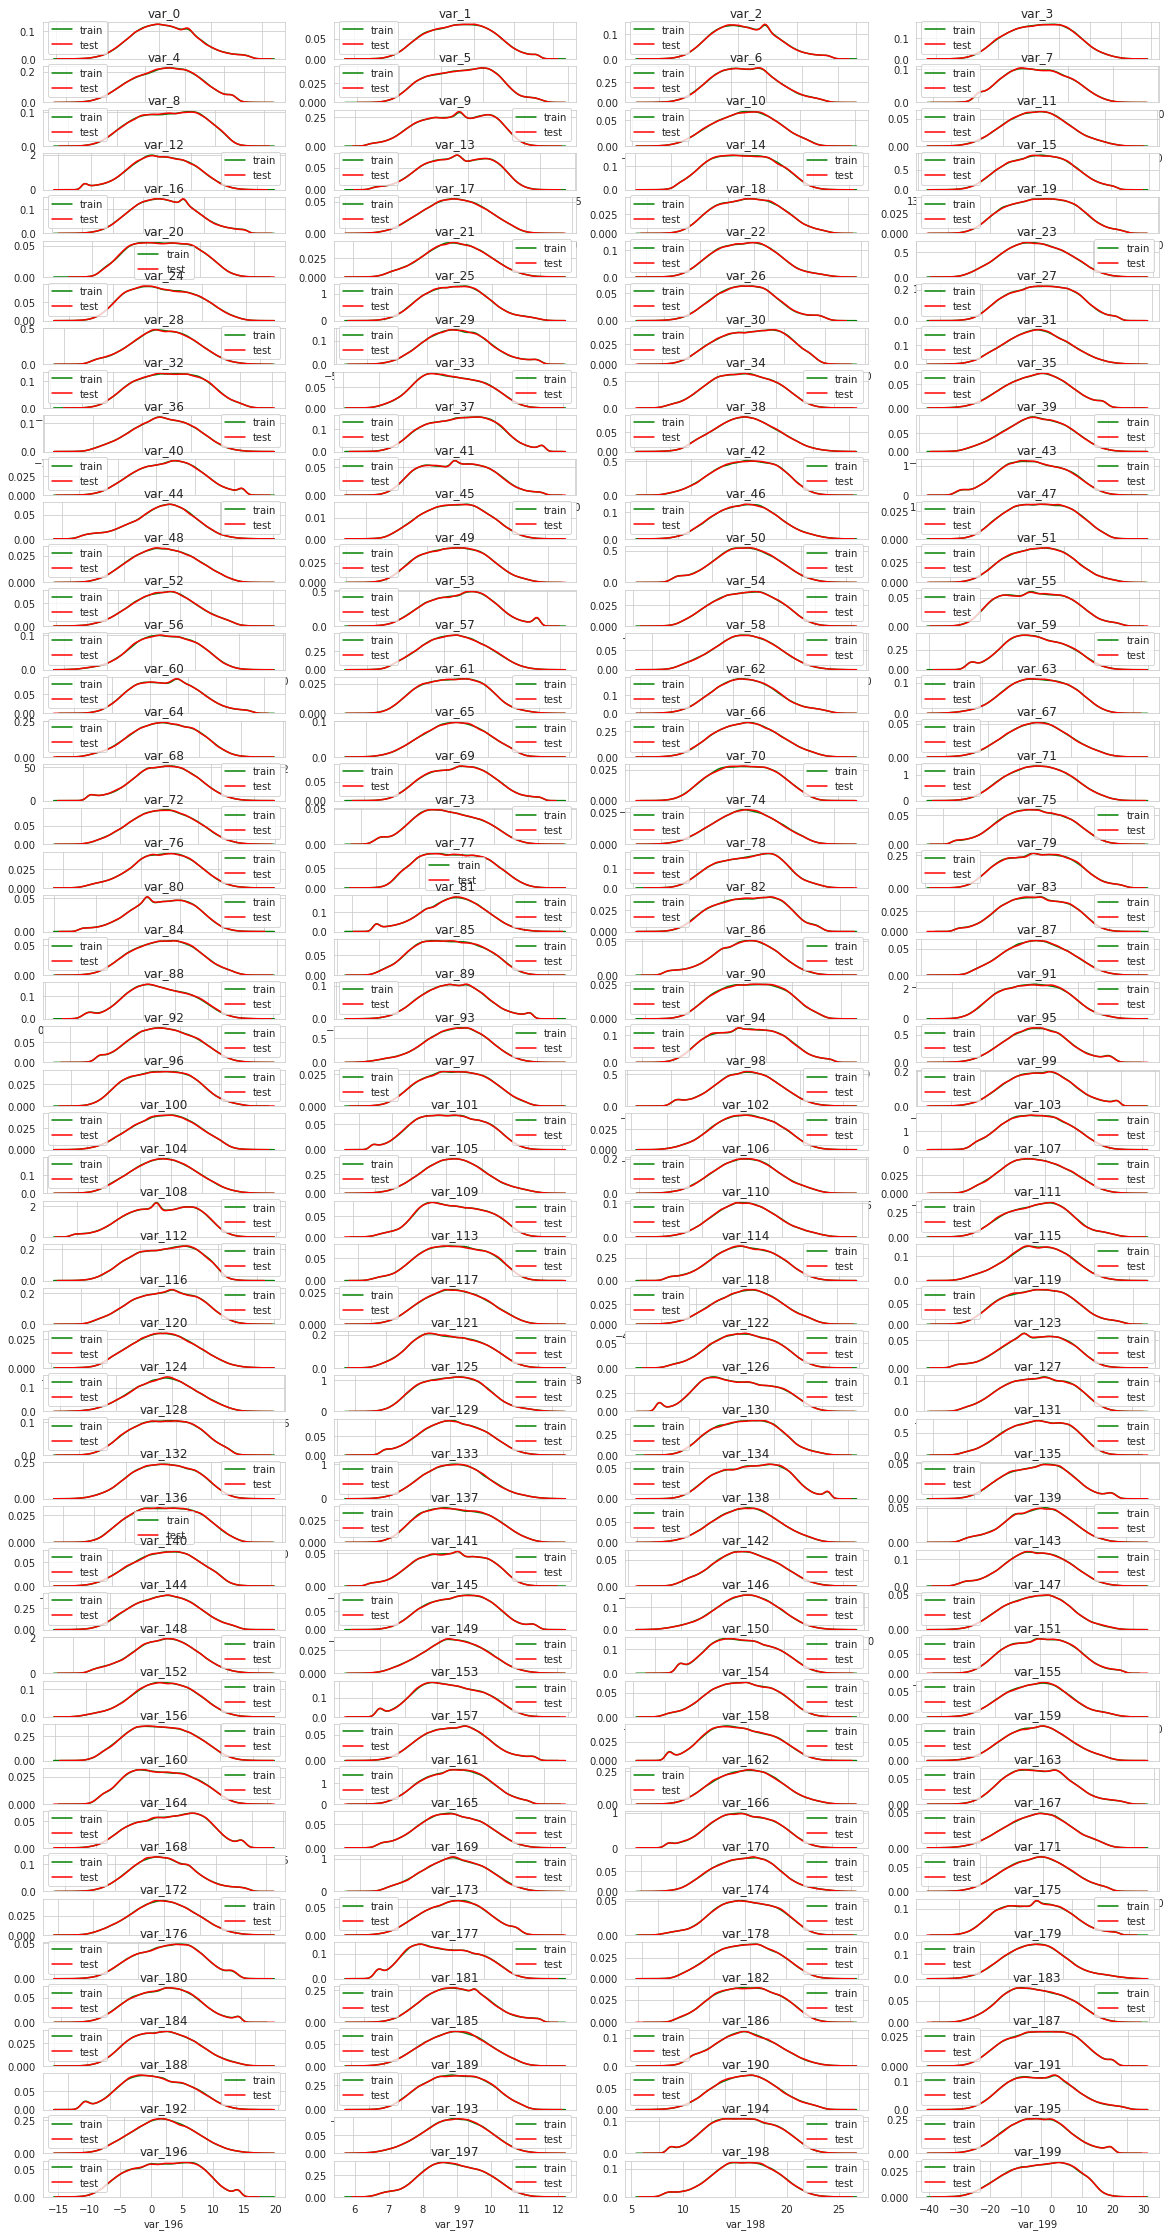

In [0]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 40))
for i,col in enumerate(numerical_features):
    plt.subplot(50,4,i+1)
    sns.distplot(train_df[col],hist=False,label='train',color='green')
    sns.distplot(test_df[col],hist=False,label='test',color='red')
    plt.title(col)

- The train and test seems to be well balanced with respect with distribution of the numeric variables.

<h3> 3.10 Univariate analysis of mean and standard deviation of train and test sets</h3>

<h4> 3.10.1 Checking the mean values per row in the train and the test set. </h4>

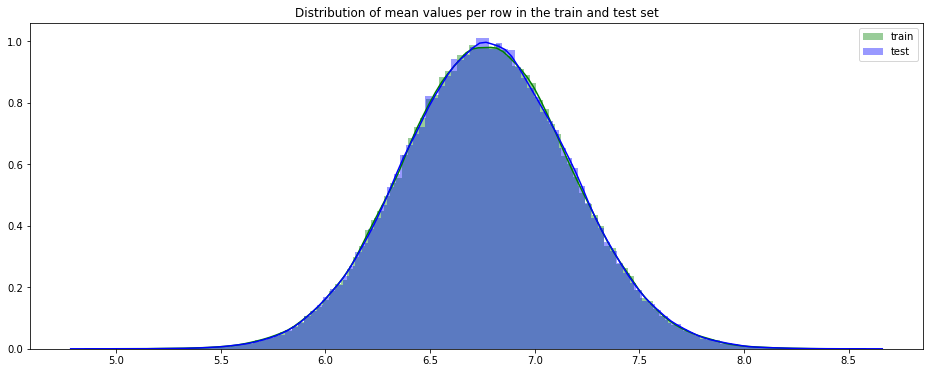

In [0]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

<h4> 3.10.2 Checking the mean values per column in the train and the test set. </h4>

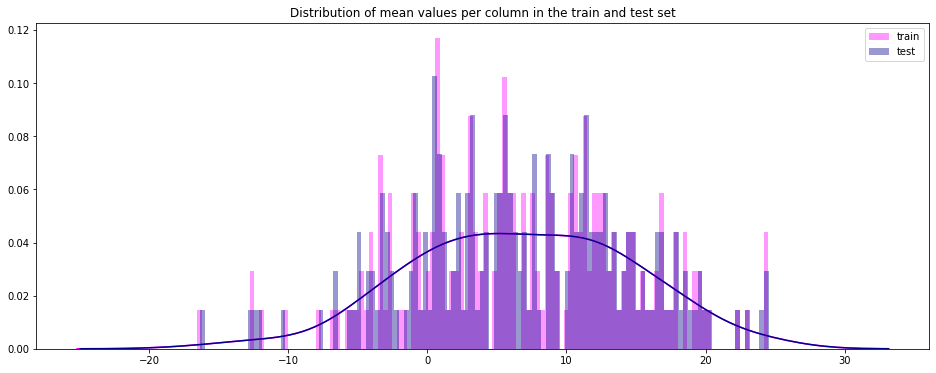

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

<h4> 3.10.3 Checking the standard deviation per row in the train and test set.</h4>

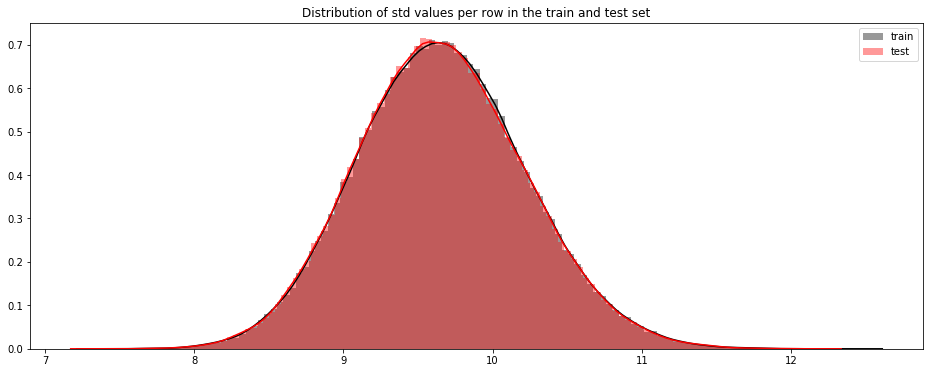

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

<h4> 3.10.4 Checking the standard deviation per column in the train and test set.</h4>

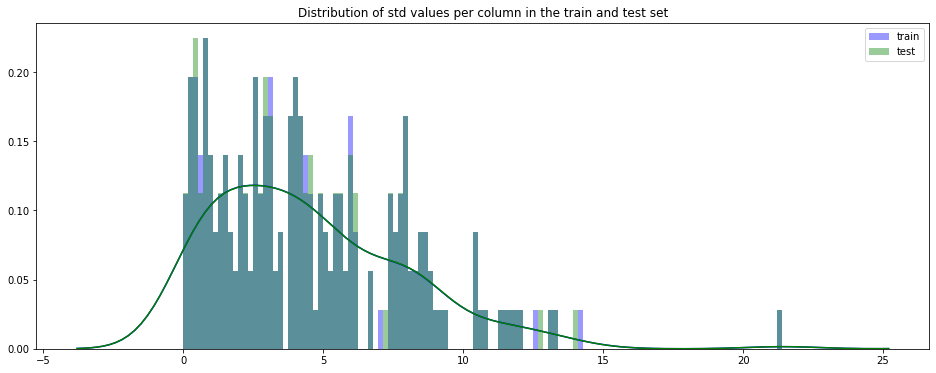

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

<h3> 3.11 Univariate analysis on mean values based on targets of the train set.</h3>

<h4> 3.11.1 Mean values per row in the train set</h4>

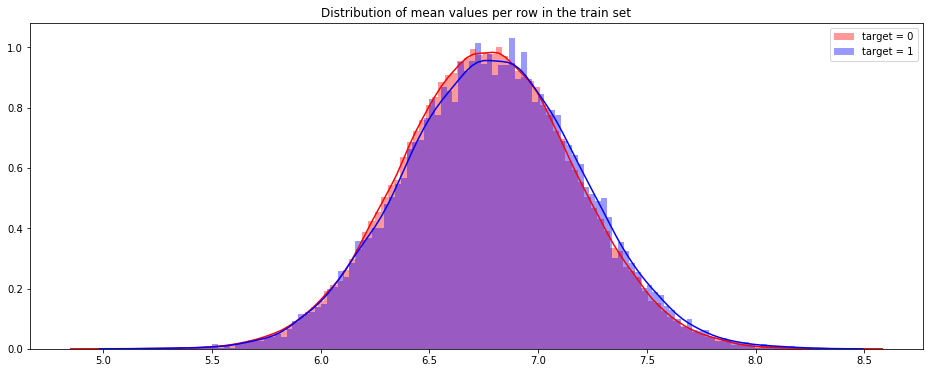

In [0]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<h4> 3.11.2 Mean values per column in the train set. </h4>

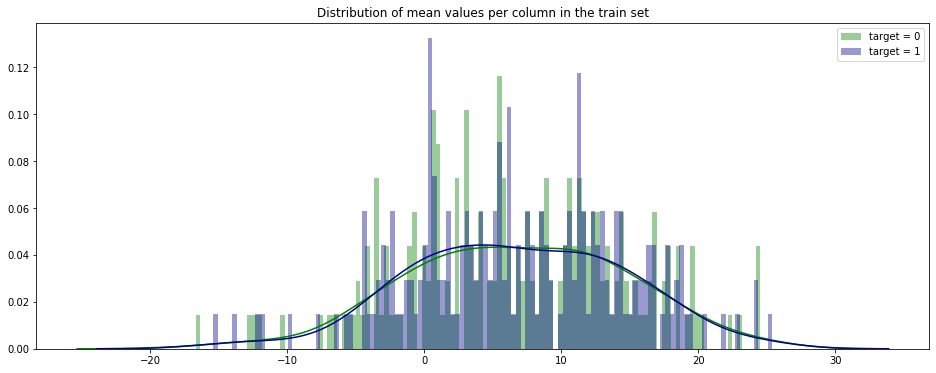

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<h3> 3.12 Univariate analysis on min values in the train set and the test set.</h3>

<h4>3.12.1 Distribution of min values per row in the train and test set</h4>

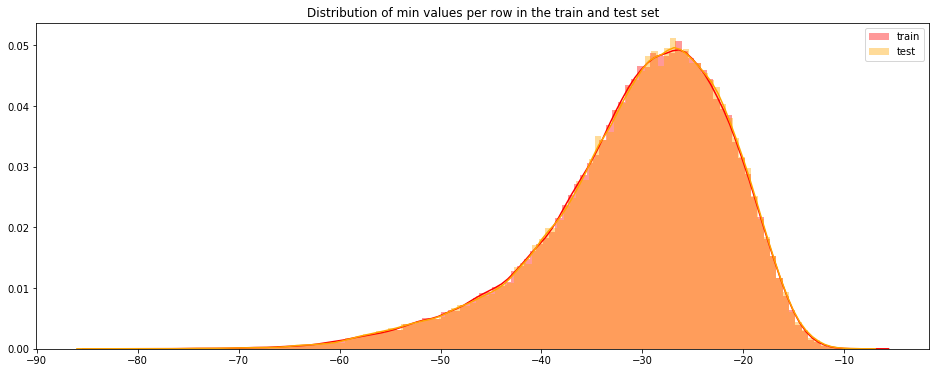

In [0]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_df[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

<h4>3.12.2 Distribution of min values per column in the train and test set </h4>

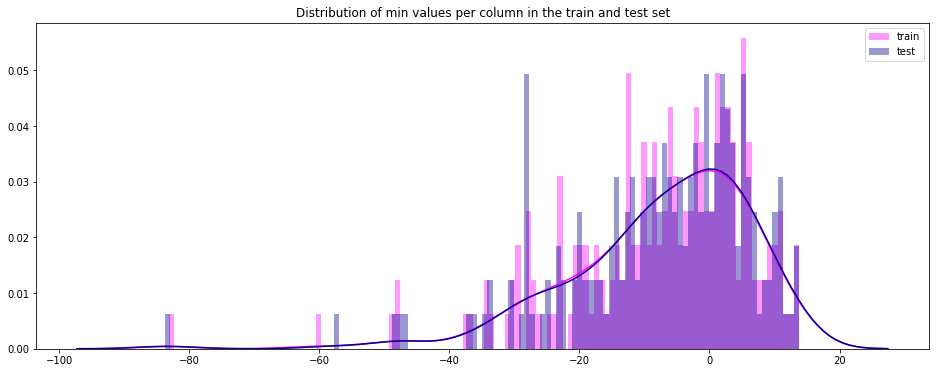

In [0]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train_df[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

<h3> 3.13 Univariate analysis on max values in the train set and the test set.</h3>

<h4>3.13.1 Distribution of max values per row in the train and test set</h4>

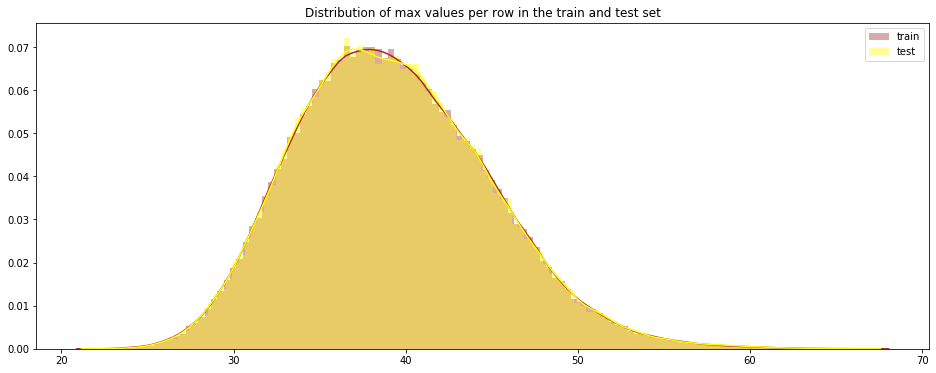

In [0]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_df[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

<h4> 3.13.2 Distribution of max values per column in the train and test set </h4>

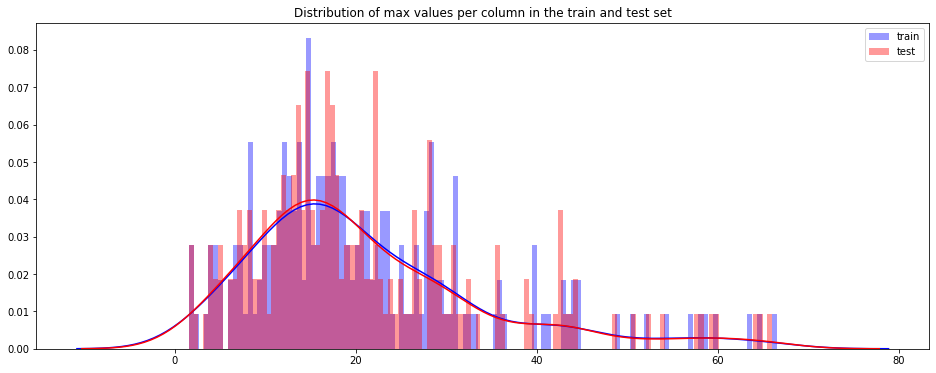

In [0]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train_df[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

<h3> 3.14 Univariate analysis on min values based on targets of the train set.</h3>

<h4>3.14.1 Distribution of min values per row in the train set </h4>

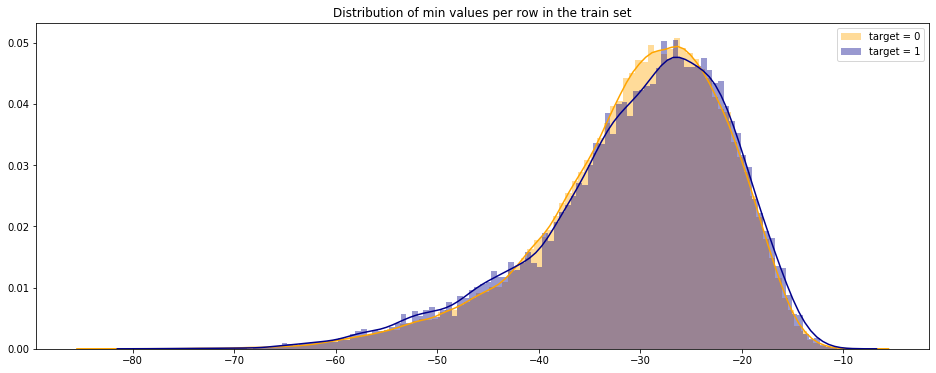

In [0]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<h4> 3.14.2 Distribution of min values per column in the train set </h4>

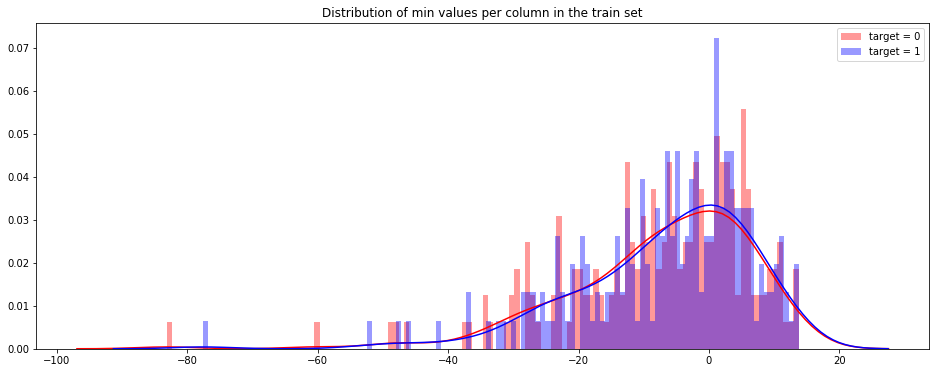

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<h3> 3.15 Univariate analysis on max values based on targets of the train set.</h3>

<h4> 3.15.1 Distribution of max values per row in the train set </h4>

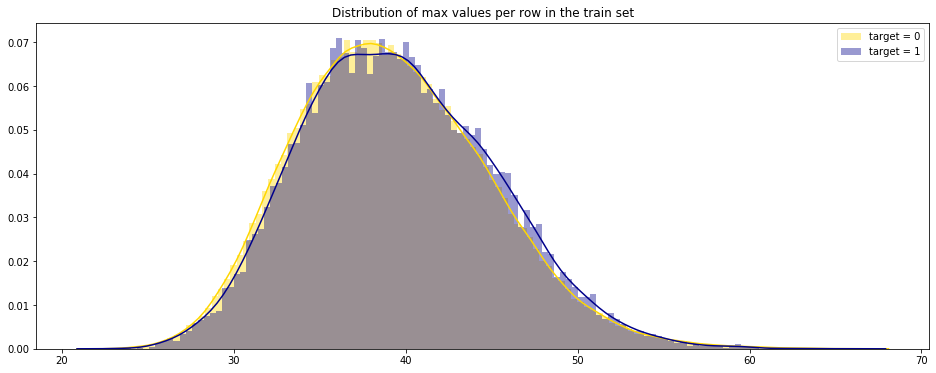

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<h4> 3.15.2 Distribution of max values per column in the train set </h4>

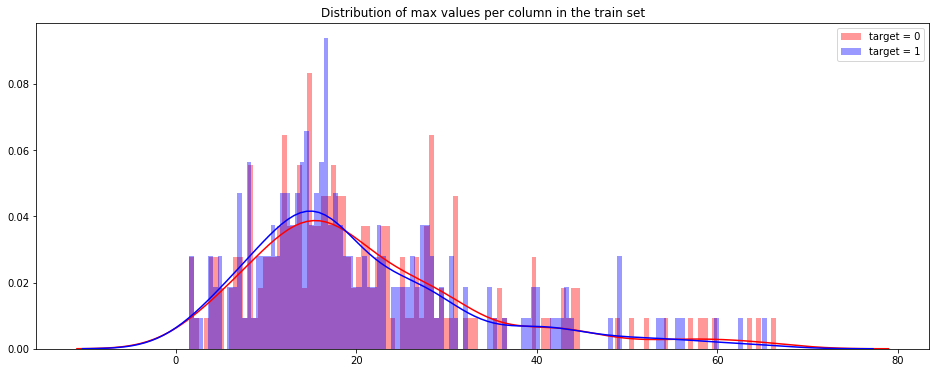

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<h3> 3.16 Univariate analysis on skew values in the train set and the test set.</h3>

<h4> 3.16.1 Distribution of skew per row in the train and test set </h4>

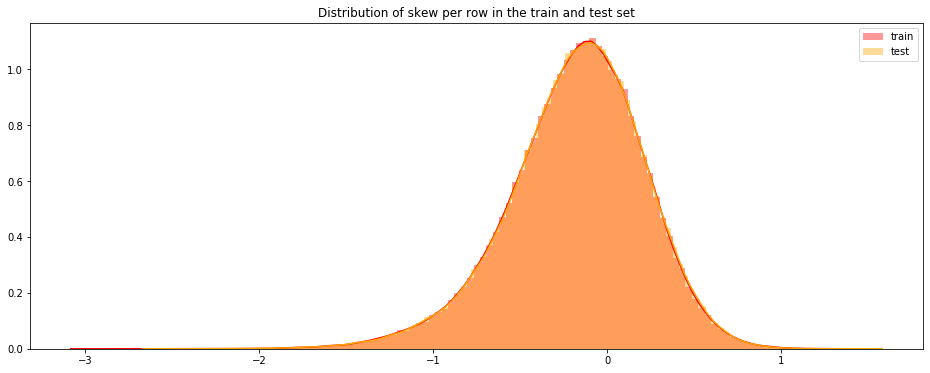

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()


<h4> 3.16.2 Distribution of skew per column in the train and test set </h4>

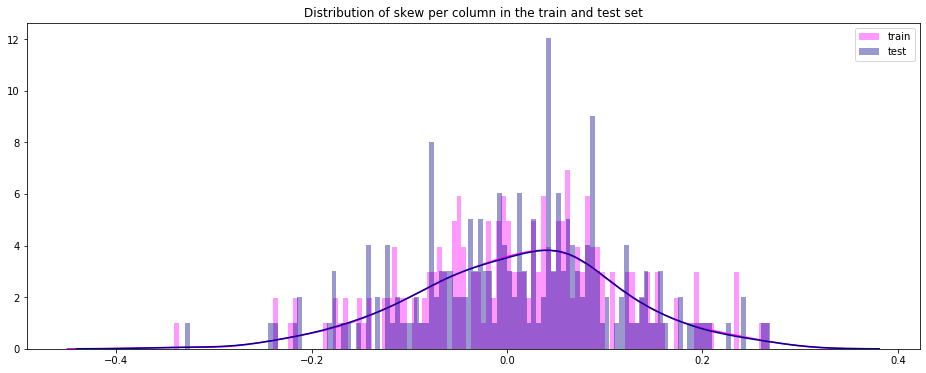

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

<h3> 3.17 Univariate analysis on kurtosis values in the train set and the test set.</h3>

<h4> 3.17.1 Distribution of kurtosis per row in the train and test set </h4>

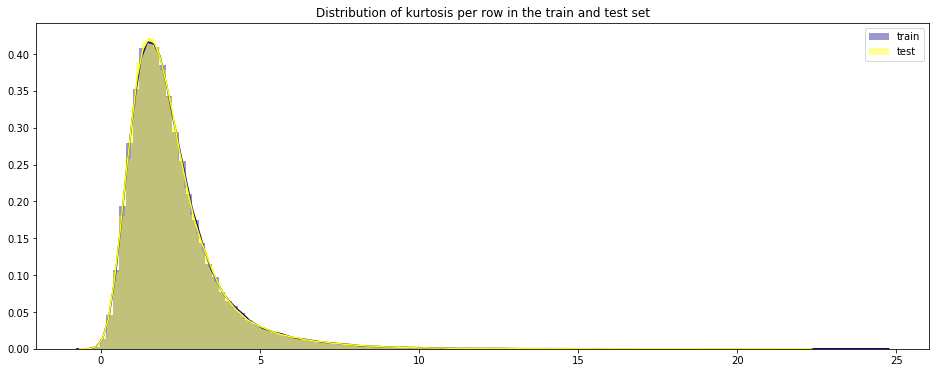

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

<h4> 3.17.2 Distribution of kurtosis per column in the train and test set </h4>

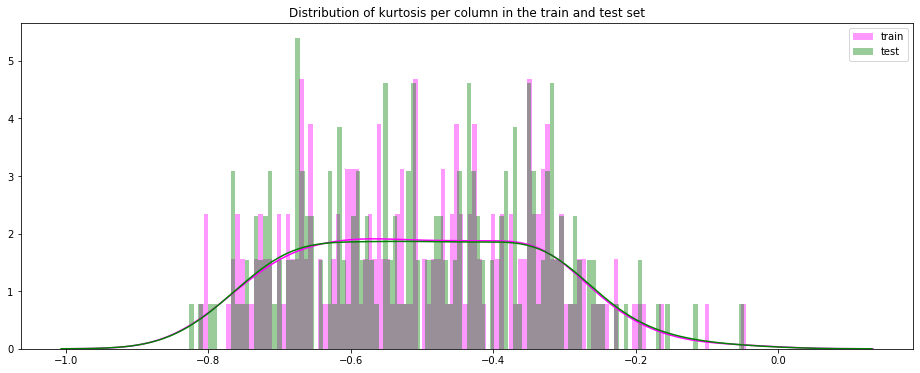

In [0]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

<h3> 3.18 Univariate analysis on skew values based on targets of the train set.</h3>

<h4> 3.18.1 Distribution of skew values per row in the train set </h4>

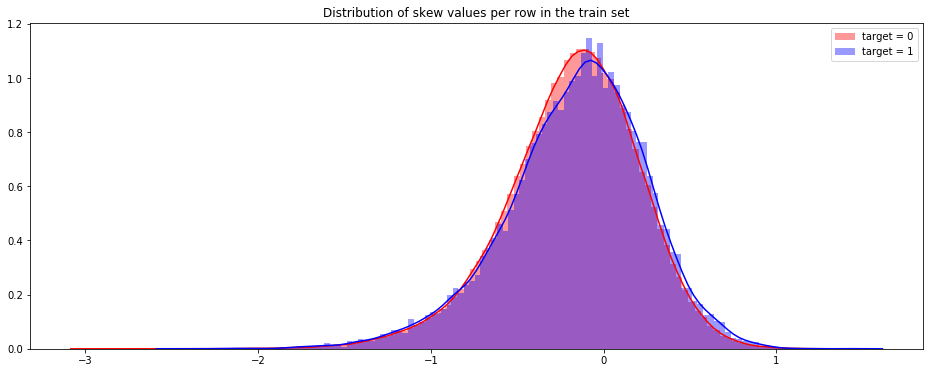

In [0]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<h4> 3.18.2 Distribution of skew values per column in the train set </h4>

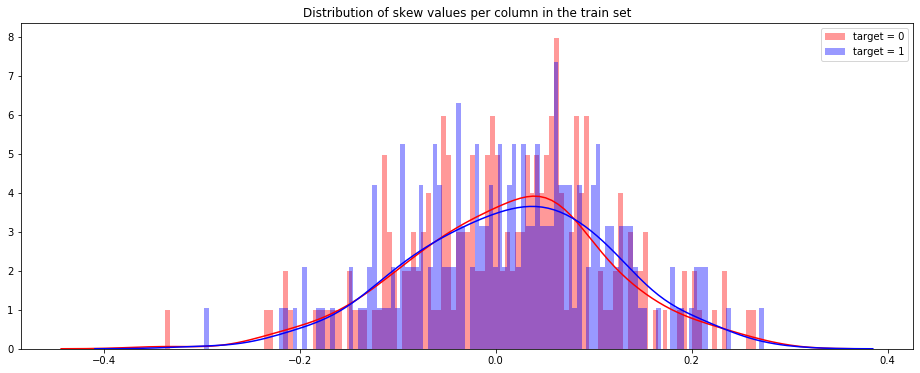

In [0]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<h3> 3.19 Univariate analysis on kurtosis values based on targets of the train set.</h3>

<h4> 3.19.1 Distribution of kurtosis values per row in the train set </h4> 

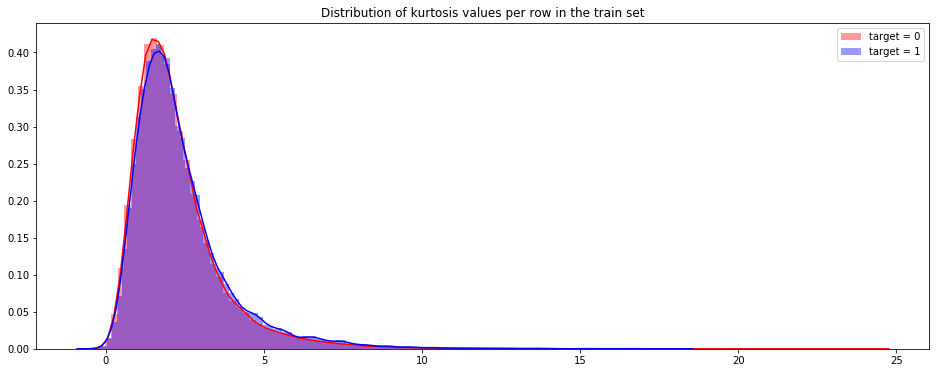

In [0]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<h4> 3.19.2 Distribution of kurtosis values per column in the train set </h4>

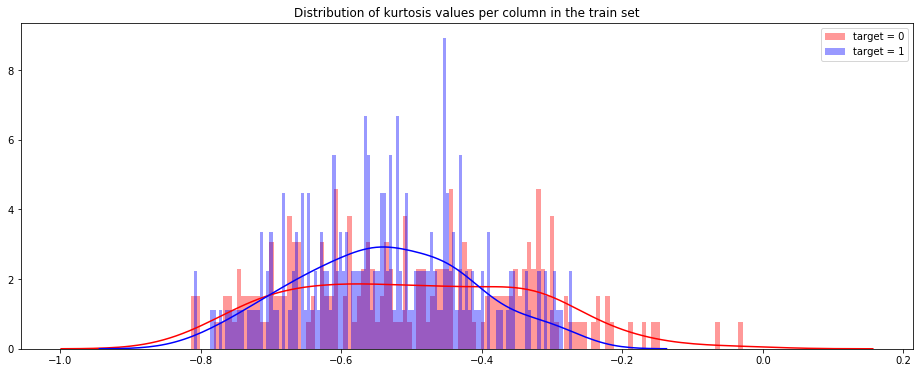

In [0]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<h1> 4. Correlation Analysis </h1>

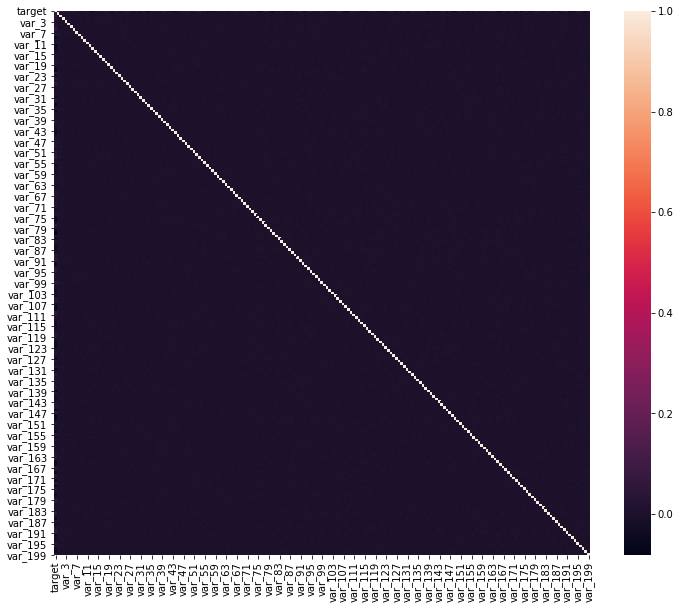

In [0]:
train_corr=train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(train_corr)

- If value of correlation coefficient is +1 or -1, then variables are strongly connected to each other and when correlation is 0, then variables are not correlated to each other and are independent. Here, variables are independent to each other.

<h1> 5. Analysing the unique value count of the features. </h1>

In [0]:
df_no=train_df.loc[train_df.target==0,:].drop(['ID_code','target'],axis=1)
df_yes=train_df.loc[train_df.target==1,:].drop(['ID_code','target'],axis=1)

In [37]:
df_yes.head(1)

var_0   var_1    var_2  var_3  ...  var_196  var_197  var_198  var_199
13  16.3699  1.5934  16.7395  7.333  ...   9.6846   9.0419  15.6064 -10.8529

[1 rows x 200 columns]

In [38]:
df_no.head(1)

var_0   var_1    var_2  var_3  ...  var_196  var_197  var_198  var_199
0  8.9255 -6.7863  11.9081  5.093  ...   7.8784   8.5635  12.7803  -1.0914

[1 rows x 200 columns]

In [40]:
df_no_unique=df_no.nunique()
df_yes_unique=df_yes.nunique()
df_yes_unique.var_170

18646

In [41]:
df_no_unique.var_170

106555

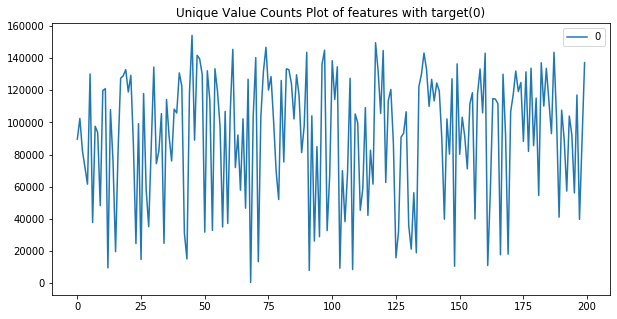

In [43]:
plt.figure(figsize=(10,5))
plt.plot(df_no_unique.values, label = '0')
plt.title('Unique Value Counts Plot of features with target(0)')
plt.legend()

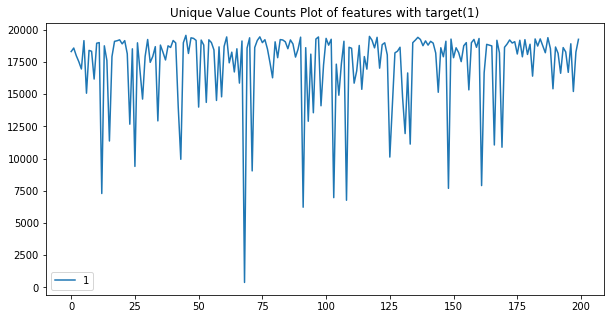

In [44]:
plt.figure(figsize=(10,5))
plt.plot(df_yes_unique.values, label = '1')
plt.title('Unique Value Counts Plot of features with target(1)')
plt.legend()

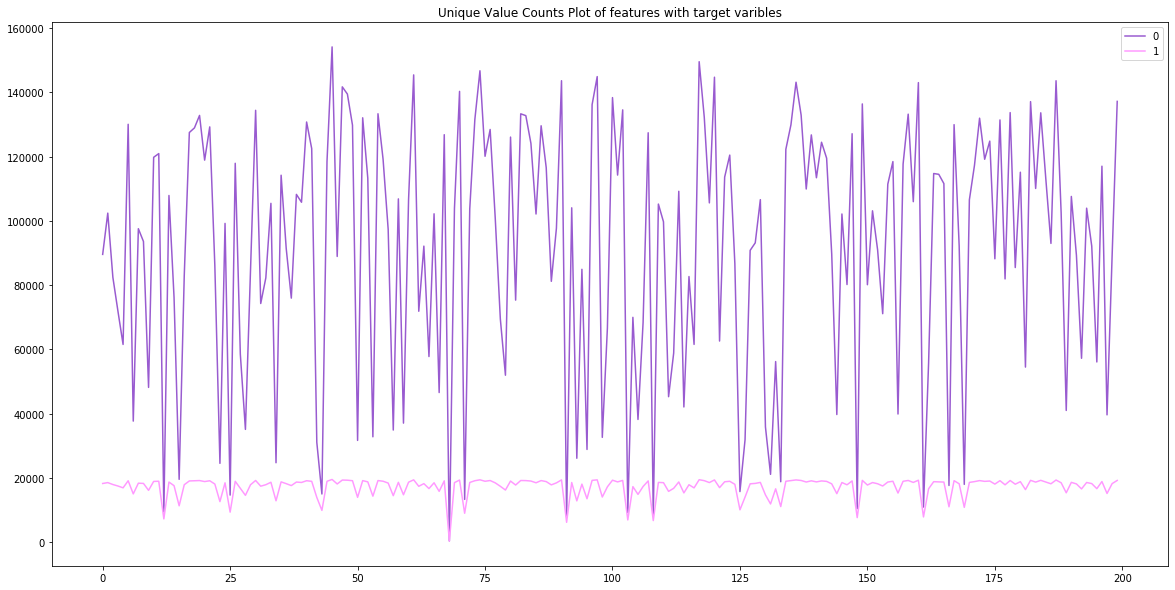

In [45]:
plt.figure(figsize=(20,10))
plt.plot(df_no_unique.values, label = '0',c='#995BD0')
plt.plot(df_yes_unique.values, label = '1',c='#FF99FF')
plt.title('Unique Value Counts Plot of features with target varibles')
plt.legend()

* As the data is imbalanced there will be some difference in there count values. So 200 new features representing the count of that particular value in that feature can be been created.

In [0]:
data = train_df.drop(['ID_code','target'],axis=1)
test = test_df.drop(['ID_code'],axis=1)
d_uq=data.nunique()
t_uq=test.nunique()

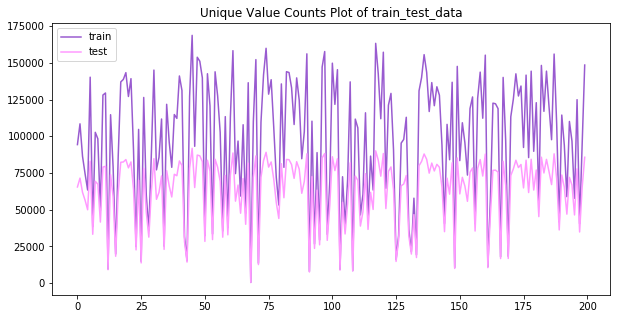

In [47]:
plt.figure(figsize=(10,5))
plt.plot(d_uq.values, label = 'train',c='#995BD0')
plt.plot(t_uq.values, label = 'test',c='#FF99FF')
plt.title('Unique Value Counts Plot of train_test_data')
plt.legend()
plt.show()

<h4> It can be seen that there are less unique values in test data as compared to train data. 

<h1> 6. PCA </h1>

<h3> Performing Principal Component Analysis to find how many features of the total existing features explain the maximum variance in the dataset </h3>

In [0]:
train_tran = train_df.iloc[:, 2:]


In [0]:
pca = PCA()
pca.fit(train_tran)
pca.data = pca.transform(train_tran)

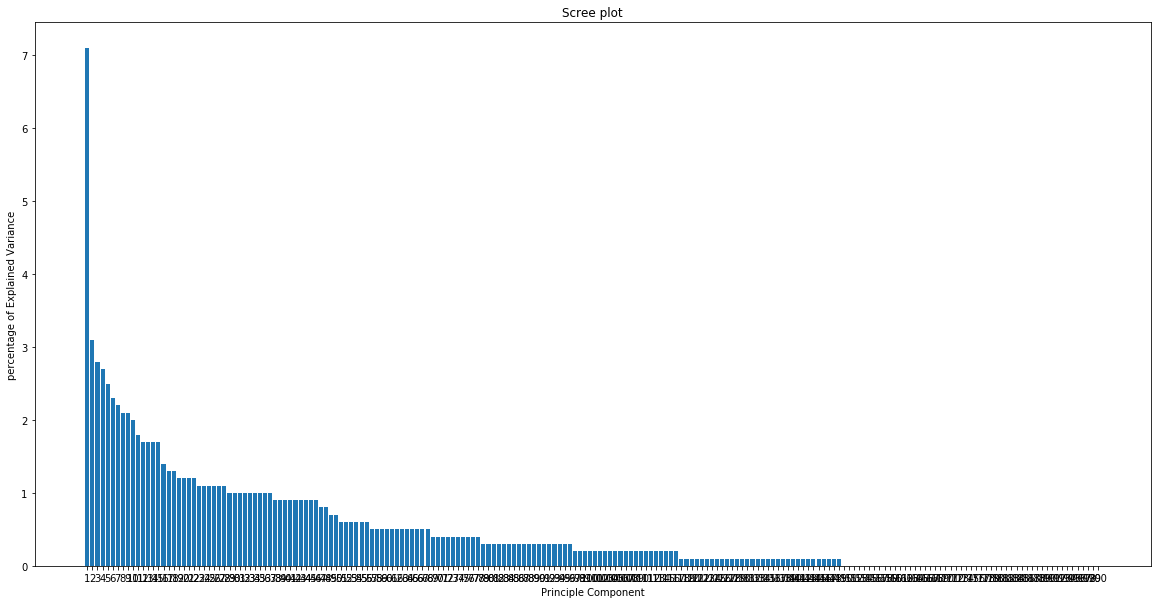

In [0]:
#Percentage variance of each pca component stands for
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
#Create labels for the scree plot
labels = [str(x) for x in range(1, len(per_var)+1)]

#Plot the data
plt.figure(figsize = (20, 10))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label = labels)
plt.ylabel('percentage of Explained Variance')
plt.xlabel('Principle Component')
plt.title('Scree plot')
plt.show()

In [0]:

print('PC1 + PC150 add up to ' +  str(sum(per_var[:150])) + ' % of the variance')


PC1 + PC150 add up to 99.3999999999999 % of the variance


- It turns out that out of the existing 200 features top 150 features explain approximately 99.5% of the total variance of the dataset

<h1>7. Feature Engineering</h1>

<h3> Adding some basic features </h3>

In [20]:
#creating new features and storing them by creating a new pandas dataframe
train_df_basic_f=pd.read_csv('train.csv')
test_df_basic_f=pd.read_csv('test.csv')
#remove outliers in train and test data
for col in tqdm(numerical_features):
    train_df_basic_f=train_df_basic_f.loc[(~chauvenet(train_df_basic_f[col].values))]
for col in tqdm(numerical_features):
    test_df_basic_f=test_df_basic_f.loc[(~chauvenet(test_df_basic_f[col].values))]

100%|██████████| 200/200 [00:16<00:00, 11.97it/s]


<h3> 7.1 New features by taking the unique value count of all 200 originally existing features and thus creating 200 more new features</h3>

In [0]:
for feat in ['var_' + str(x) for x in range(200)]:
  train_count_values=train_df_basic_f.groupby(feat)[feat].count()
  test_count_values=test_df_basic_f.groupby(feat)[feat].count()
  train_df_basic_f['new_'+feat]=train_count_values.loc[train_df[feat]].values
  test_df_basic_f['new_'+feat]=test_count_values.loc[test_df_basic_f[feat]].values

In [22]:
train_df_basic_f.head()

ID_code  target    var_0  ...  new_var_197  new_var_198  new_var_199
0  train_0       0   8.9255  ...           13            5            2
1  train_1       0  11.5006  ...           12            2            1
2  train_2       0   8.6093  ...            8            2            2
3  train_3       0  11.0604  ...            4            2            2
4  train_4       0   9.8369  ...            6            2            2

[5 rows x 402 columns]

In [23]:
test_df_basic_f.head()

ID_code    var_0    var_1  ...  new_var_197  new_var_198  new_var_199
0  test_0  11.0656   7.7798  ...            5            5            4
1  test_1   8.5304   1.2543  ...            9            3            7
2  test_2   5.4827 -10.3581  ...            5            6            2
3  test_3   8.5374  -1.3222  ...            1            6            3
4  test_4  11.7058  -0.1327  ...            6            5            5

[5 rows x 401 columns]

- From the above result it can be seen that 200 new features have been derived.

<h3> 7.2 New features by taking the sum, min_value, max_value, mean_value, std_dev_value, skew_value, kurtosis_value and the median value of the originally existing 200 features of the train set.</h3>

In [0]:
idx = features = train_df_basic_f.columns.values[2:202]
for df in [test_df_basic_f, train_df_basic_f]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [25]:
train_df_basic_f.head()

ID_code  target    var_0   var_1  ...        std      skew      kurt      med
0  train_0       0   8.9255 -6.7863  ...   9.331540  0.101580  1.331023  6.77040
1  train_1       0  11.5006 -4.1473  ...  10.336130 -0.351734  4.110215  7.22315
2  train_2       0   8.6093 -2.7457  ...   8.753387 -0.056957  0.546438  5.89940
3  train_3       0  11.0604 -2.1518  ...   9.594064 -0.480116  2.630499  6.70260
4  train_4       0   9.8369 -1.4834  ...  11.287122 -1.463426  9.787399  6.94735

[5 rows x 410 columns]

In [26]:
test_df_basic_f.head()

ID_code    var_0    var_1    var_2  ...        std      skew      kurt      med
0  test_0  11.0656   7.7798  12.9536  ...   9.910632 -0.088518  1.871262  7.31440
1  test_1   8.5304   1.2543  11.3047  ...   9.541267 -0.559785  3.391068  6.43960
2  test_2   5.4827 -10.3581  10.1407  ...   9.967466 -0.135084  2.326901  7.26355
3  test_3   8.5374  -1.3222  12.0220  ...   8.257204 -0.167741  2.253054  6.89675
4  test_4  11.7058  -0.1327  14.1295  ...  10.043542  0.293484  2.044943  6.83375

[5 rows x 409 columns]

- From the above result it can be seen that 8 new features have been derived.

In [0]:
#saving to csv
train_df_basic_f.to_csv('basic_train.csv')
test_df_basic_f.to_csv('basic_test.csv')

In [27]:
print(train_df.shape)
print(test_df.shape)
print(train_df_basic_f.shape)
print(test_df_basic_f.shape)

(198264, 202)
(198250, 201)
(198264, 410)
(198250, 409)


<h4> From the above result it can be seen that in total of 408 new features have been derived by using some basic feature engineering techniques.

<h3> Genetic Feature Engineering. </h3>

<h4> Using 199 of the 200 features to create an estimation of the missing feature. This estimation can be considered to be a "new feature" or a new classification of the current 199 features as being a member of the missing feature target. This can be repeated for every feature, giving 200 new features to add to the training (and testing) sets. </h4>

In [0]:
#creating new features and storing them by creating a new pandas dataframe
train_df_genetic_f=pd.read_csv('train.csv')
test_df_genetic_f=pd.read_csv('test.csv')
#remove outliers in train and test data
for col in tqdm(numerical_features):
    train_df_genetic_f=train_df_genetic_f.loc[(~chauvenet(train_df_genetic_f[col].values))]
for col in tqdm(numerical_features):
    test_df_genetic_f=test_df_genetic_f.loc[(~chauvenet(test_df_genetic_f[col].values))]

100%|██████████| 200/200 [00:22<00:00,  8.42it/s]


In [0]:
X1 = train_df_genetic_f.drop(['ID_code','target'],axis=1)
X_test1 = test_df_genetic_f.drop('ID_code',axis=1)

<h3> Using the python library 'gplearn' for the process </h3>

<h4> From the website 'https://gplearn.readthedocs.io/en/stable/intro.html' </h4>
<h4> "Symbolic regression is a machine learning technique that aims to identify an underlying mathematical expression that best describes a relationship. It begins by building a population of naive random formulas to represent a relationship between known independent variables and their dependent variable targets in order to predict new data. Each successive generation of programs is then evolved from the one that came before it by selecting the fittest individuals from the population to undergo genetic operations." </h4>


In [0]:
# Create a fitness function that is the mean absolute percentage error
def _my_fit(y, y_pred, w):
    diffs = np.abs(y - y_pred)  
    return 100. * np.average(diffs, weights=w)
my_fit = make_fitness(_my_fit, greater_is_better=False)

In [0]:
# Choose the mathematical functions we will combine together
function_set = ['add', 'sub', 'mul', 'div', 'log', 
                'sqrt', 'log', 'abs', 'neg', 'inv', 
                'max', 'min', 
                'sin', 'cos', 'tan' ] 

# Create the genetic learning regressor
gp = SymbolicRegressor(function_set=function_set, metric = my_fit,
                       verbose=1, generations = 3, 
                       random_state=0, n_jobs=-1)

In [0]:
# Using NUMPY structures, remove one feature (column of data) at a time from the training set
# Use that removed column as the target for the algorithm
# Use the genetically engineered formula to create the new feature
# Do this for both the training set and the test set

X1a = np.array(X1)
sam = X1a.shape[0]
col = X1a.shape[1]
X2a = np.zeros((sam, col))

X_test1a = np.array(X_test1)
sam_test = X_test1a.shape[0]
col_test = X_test1a.shape[1]
X_test2a = np.zeros((sam_test, col_test))

for i in range(col) :
    X = np.delete(X1a,i,1)
    y = X1a[:,i]
    gp.fit(X, y) 
    X2a[:,i] = gp.predict(X)
    X = np.delete(X_test1a, i, 1)
    X_test2a[:,i] = gp.predict(X)
    
X2 = pd.DataFrame(X2a)
X_test2 = pd.DataFrame(X_test2a) 

In [0]:
train_genetic = X1.to_numpy()

In [0]:
test_genetic = X_test1.to_numpy()

In [0]:
train_genetic_ = X2.to_numpy()
test_genetic_ = X_test2.to_numpy()

In [0]:
X_train_genetic_f=np.column_stack((train_genetic, train_genetic_))

In [0]:
X_test_genetic_f=np.column_stack((test_genetic, test_genetic_))

In [0]:
print(X_train_genetic_f.shape)
print(X_test_genetic_f.shape)

(198264, 400)
(198250, 400)


In [0]:
train_genetic_df=pd.DataFrame(data=X_train_genetic_f[0:, 0:],
                              index=[i for i in range(X_train_genetic_f.shape[0])],
                              columns=['var'+str(i) for i in range(X_train_genetic_f.shape[1])])

In [0]:
test_genetic_df=pd.DataFrame(data=X_test_genetic_f[0:, 0:],
                              index=[i for i in range(X_test_genetic_f.shape[0])],
                              columns=['var'+str(i) for i in range(X_test_genetic_f.shape[1])])

In [0]:
train_genetic_df['ID_code']=train_df['ID_code']

In [0]:
train_genetic_df['target']=train_df['target']
test_genetic_df['ID_code']=test_df['ID_code']

In [0]:
print(train_genetic_df.shape)
print(test_genetic_df.shape)

(198264, 402)
(198250, 401)


In [0]:
#saving to csv
train_genetic_df.to_csv('genetic_train.csv')
test_genetic_df.to_csv('genetic_test.csv')

<h1> 8. Models for Classification.

<h3> Note:- Since after the feature engineering now there are three sets of datasets, 



- Original dataset with no additional features.
- Dataset with the original features as well as new basic features.
- Dataset with the original features as well as genetically engineered features.

<h4> All the machine learning models are tried on these three variants of the datasets. </h4>

<h3> 8.1. Logistic Regression without class balancing.

<h4> 8.1.1 On the original dataset with no added features.

<h4> Preparing the dataset.

In [0]:
features = train_df.drop(['ID_code','target'],axis=1)
target = train_df['target']
print(features.shape, target.shape)

(198264, 200) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 200) (158611,)
(39653, 200) (39653,)


<h4> Finding the suitable parameters for the model. 

In [0]:
parameters={'C':[10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4], 'penalty':['l1', 'l2']}
lr=LogisticRegression()
model=GridSearchCV(lr, parameters, scoring='roc_auc', cv=2, n_jobs=-1)
model.fit(X_train, y_train)
print(model.best_estimator_)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


<h4> Running the optimal model and looking at the results.

In [0]:
lr_optimal=LogisticRegression(C=0.001, penalty='l2')

lr_optimal.fit(X_train, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_optimal.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_optimal.predict_proba(X_test)[:, 1])

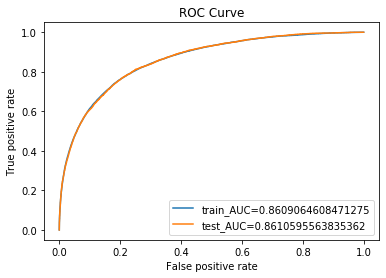

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

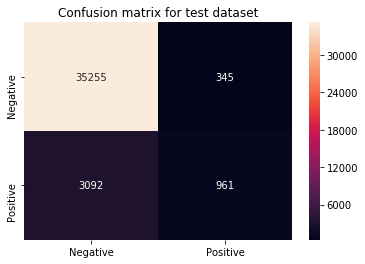

In [0]:
pred=lr_optimal.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

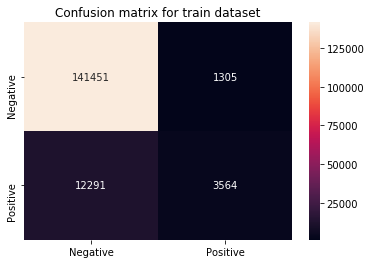

In [0]:
predictions=lr_optimal.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.92      0.99      0.95     35600
positive_class       0.74      0.24      0.36      4053

      accuracy                           0.91     39653
     macro avg       0.83      0.61      0.66     39653
  weighted avg       0.90      0.91      0.89     39653



<h4> From the above results it can be observed that only logistic regression on the original dataset with no added features gave good results. 

<h4> 8.1.2 On the dataset with the original and the basic features.

<h4> Preparing the dataset.

In [0]:
features = train_df_basic_f.drop(['ID_code','target'],axis=1)
features = features.drop([features.columns[0]], axis='columns')
target = train_df['target']
print(features.shape, target.shape)

(198264, 408) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 408) (158611,)
(39653, 408) (39653,)


<h4> Finding the suitable parameters for the model.

In [0]:
parameters={'C':[10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4], 'penalty':['l1', 'l2']}
lr=LogisticRegression(solver='saga')
model=GridSearchCV(lr, parameters, scoring='roc_auc', cv=2, n_jobs=-1)
model.fit(X_train, y_train)
print(model.best_estimator_)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


<h4> Running the optimal model and looking at the results.

In [0]:
lr_optimal=LogisticRegression(C=0.1, penalty='l1', solver='saga')

lr_optimal.fit(X_train, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_optimal.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_optimal.predict_proba(X_test)[:, 1])

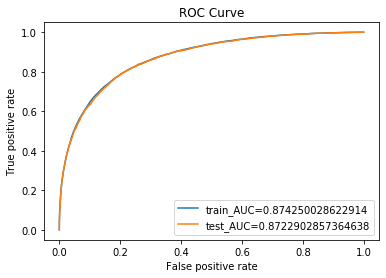

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

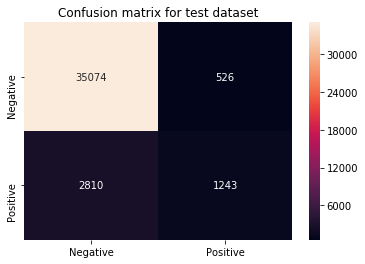

In [0]:
pred=lr_optimal.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

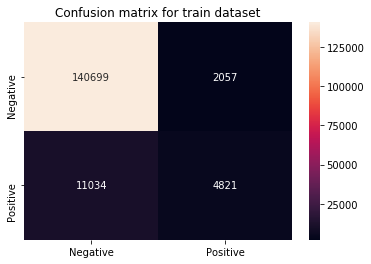

In [0]:
predictions=lr_optimal.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.93      0.99      0.95     35600
positive_class       0.70      0.31      0.43      4053

      accuracy                           0.92     39653
     macro avg       0.81      0.65      0.69     39653
  weighted avg       0.90      0.92      0.90     39653



<h4> From the above results it can be seen that there is an improvement in the performance of the model due to the added parameters but the improvement is very minute.

<h4> 8.1.3 On the dataset with original features and the genetic features

<h4> Preparing the dataset. </h4>

In [0]:
features = train_df_genetic_f.drop(['ID_code','target'],axis=1)
features = features.drop([features.columns[0]], axis='columns')
target = train_df['target']
print(features.shape, target.shape)

(198264, 400) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 400) (158611,)
(39653, 400) (39653,)


<h4> Finding the optimal parameters for the model.

In [0]:
parameters={'C':[10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4], 'penalty':['l1', 'l2']}
lr=LogisticRegression(solver='saga')
model=GridSearchCV(lr, parameters, scoring='roc_auc', cv=2, n_jobs=-1)
model.fit(X_train, y_train)
print(model.best_estimator_)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


<h4> Running the model and looking at the results. </h4>

In [0]:
lr_optimal=LogisticRegression(C=100, penalty='l1',solver='saga')

lr_optimal.fit(X_train, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_optimal.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_optimal.predict_proba(X_test)[:, 1])

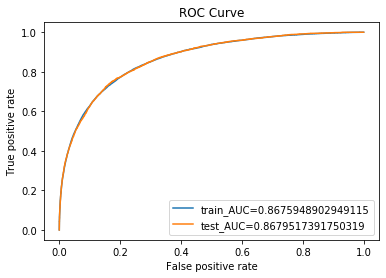

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

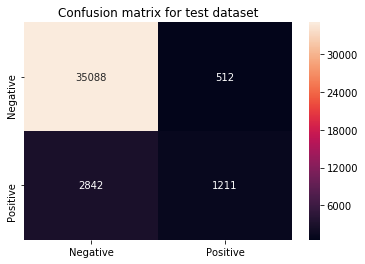

In [0]:
pred=lr_optimal.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

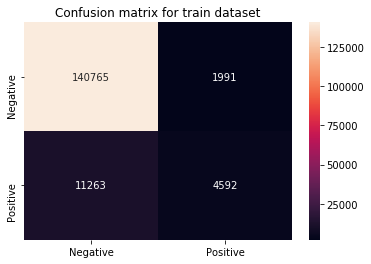

In [0]:
predictions=lr_optimal.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.93      0.99      0.95     35600
positive_class       0.70      0.30      0.42      4053

      accuracy                           0.92     39653
     macro avg       0.81      0.64      0.69     39653
  weighted avg       0.90      0.92      0.90     39653



<h4> From the above results it can be seen that their is no significant improvement in the results if compared to the results obtained from just the original dataset with no added features.

<h4> Comparing the results of all the three logistic regression (with no class balancing) models.

In [2]:
x = PrettyTable()
x.title = 'Results of all the three logistic regression (with no class balancing) models.'
x.field_names = ['Dataset form', 'Test AUC score', 'Train AUC score']
x.add_row(['Only with original features', 0.86105, 0.86090])
x.add_row(['With original and basic features', 0.87229, 0.87425 ])
x.add_row(['With original and genetic features',0.86795, 0.86759])
print(x)

+-----------------------------------------------------------------------------------+
|   Results of all the three logistic regression (with no class balancing) models.  |
+------------------------------------------+-------------------+--------------------+
|               Dataset form               |   Test AUC score  |  Train AUC score   |
+------------------------------------------+-------------------+--------------------+
|       Only with original features        |      0.86105      |       0.8609       |
|     With original and basic features     |      0.87229      |      0.87425       |
|    With original and genetic features    |      0.86795      |      0.86759       |
+------------------------------------------+-------------------+--------------------+


<h3> 8.2. Logistic Regression with class balancing.

<h4> 8.2.1. On the original dataset with no added features.

<h4> Preparing the dataset.

In [0]:
features = train_df.drop(['ID_code','target'],axis=1)
target = train_df['target']
print(features.shape, target.shape)

(198264, 200) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 200) (158611,)
(39653, 200) (39653,)


<h4> Finding the suitable parameters for the models.

In [0]:
parameters={'C':[10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4], 'penalty':['l1', 'l2']}
lr=LogisticRegression(class_weight='balanced')
model=GridSearchCV(lr, parameters, scoring='roc_auc', cv=2, n_jobs=-1)
model.fit(X_train, y_train)
print(model.best_estimator_)

LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


<h4> Running the model and looking at the results.

In [0]:
lr_optimal=LogisticRegression(C=1e-05, penalty='l2', class_weight='balanced')

lr_optimal.fit(X_train, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_optimal.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_optimal.predict_proba(X_test)[:, 1])

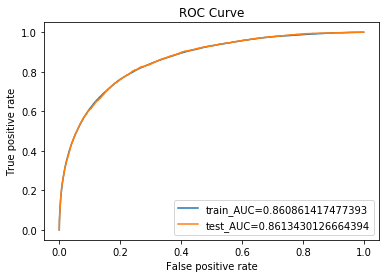

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

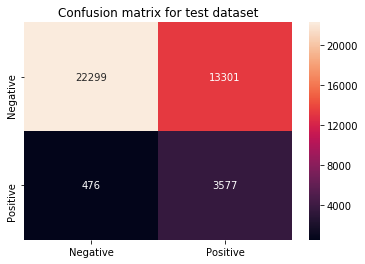

In [0]:
pred=lr_optimal.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

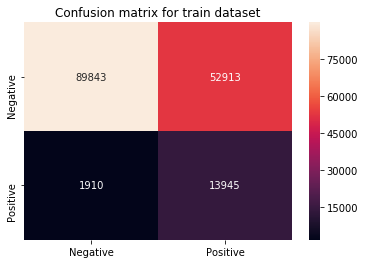

In [0]:
predictions=lr_optimal.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.98      0.63      0.76     35600
positive_class       0.21      0.88      0.34      4053

      accuracy                           0.65     39653
     macro avg       0.60      0.75      0.55     39653
  weighted avg       0.90      0.65      0.72     39653



<h4> From the above cells it can be observed that there is no change in the AUC score but the model began to perform better on positive datapoints and worse on negative datapoints.

<h4> 8.2.2. On the dataset with original and basic features </h4>

<h4> Preparing the dataset.

In [0]:
features = train_df_basic_f.drop(['ID_code','target'],axis=1)
features = features.drop([features.columns[0]], axis='columns')
target = train_df['target']
print(features.shape, target.shape)

(198264, 408) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 408) (158611,)
(39653, 408) (39653,)


<h4> Finding the suitable parameters for the model.

In [0]:
parameters={'C':[10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4], 'penalty':['l1', 'l2']}
lr=LogisticRegression(solver='saga', class_weight='balanced')
model=GridSearchCV(lr, parameters, scoring='roc_auc', cv=2, n_jobs=-1)
model.fit(X_train, y_train)
print(model.best_estimator_)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


<h4> Running the model and looking at the results.

In [0]:
lr_optimal=LogisticRegression(C=0.1, penalty='l1', solver='saga', class_weight='balanced')

lr_optimal.fit(X_train, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_optimal.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_optimal.predict_proba(X_test)[:, 1])

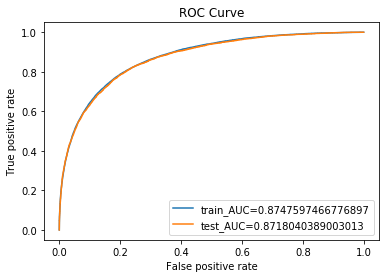

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

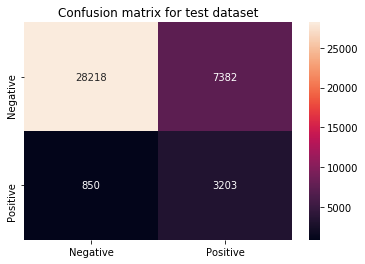

In [0]:
pred=lr_optimal.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

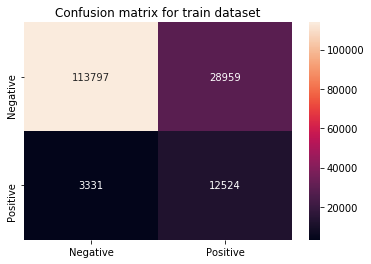

In [0]:
predictions=lr_optimal.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.97      0.79      0.87     35600
positive_class       0.30      0.79      0.44      4053

      accuracy                           0.79     39653
     macro avg       0.64      0.79      0.66     39653
  weighted avg       0.90      0.79      0.83     39653



<h4> There is no improvement in the results but the model began to perform better on positive datapoints and worse on negative datapoints.

<h4> 8.2.3. On the dataset with original features and genetic features.

<h4> Preparing the dataset.

In [0]:
features = train_df_genetic_f.drop(['ID_code','target'],axis=1)
features = features.drop([features.columns[0]], axis='columns')
target = train_df['target']
print(features.shape, target.shape)

(198264, 400) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 400) (158611,)
(39653, 400) (39653,)


<h4> Finding the suitable parameters for the model.

In [0]:
parameters={'C':[10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4], 'penalty':['l1', 'l2']}
lr=LogisticRegression(solver='saga', class_weight='balanced')
model=GridSearchCV(lr, parameters, scoring='roc_auc', cv=2, n_jobs=-1)
model.fit(X_train, y_train)
print(model.best_estimator_)

LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


<h4> Running the optimal model and looking at the results.

In [0]:
lr_optimal=LogisticRegression(C=100, penalty='l2',solver='saga', class_weight='balanced')

lr_optimal.fit(X_train, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, lr_optimal.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, lr_optimal.predict_proba(X_test)[:, 1])

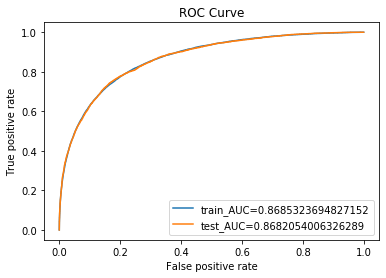

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

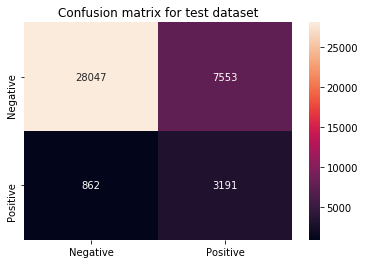

In [0]:
pred=lr_optimal.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

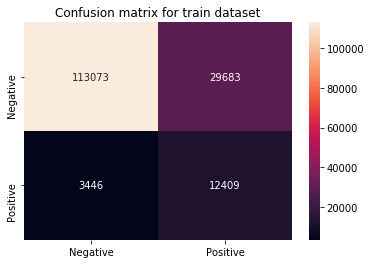

In [0]:
predictions=lr_optimal.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.97      0.79      0.87     35600
positive_class       0.30      0.79      0.43      4053

      accuracy                           0.79     39653
     macro avg       0.63      0.79      0.65     39653
  weighted avg       0.90      0.79      0.82     39653



<h4> Once again the AUC score didn't change but the model seem to perform better on positive datapoint than on negative datapoint 

<h4> Comparing the results of all the three logistic regression (with class balancing) models

In [4]:
x = PrettyTable()
x.title = 'Results of all the three logistic regression (with class balancing) models.'
x.field_names = ['Dataset form', 'Test AUC score', 'Train AUC score']
x.add_row(['Only with original features', 0.86134, 0.86086])
x.add_row(['With original and basic features', 0.87180, 0.87475 ])
x.add_row(['With original and genetic features',0.86820, 0.86853])
print(x)

+-------------------------------------------------------------------------------+
|  Results of all the three logistic regression (with class balancing) models.  |
+----------------------------------------+------------------+-------------------+
|              Dataset form              |  Test AUC score  |  Train AUC score  |
+----------------------------------------+------------------+-------------------+
|      Only with original features       |     0.86134      |      0.86086      |
|    With original and basic features    |      0.8718      |      0.87475      |
|   With original and genetic features   |      0.8682      |      0.86853      |
+----------------------------------------+------------------+-------------------+


<h3> 8.3. Decision Tree

<h4> 8.3.1 On the original dataset with no added features.

<h4> Preparing the dataset.

In [0]:
features = train_df.drop(['ID_code','target'],axis=1)
target = train_df['target']
print(features.shape, target.shape)

(198264, 200) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 200) (158611,)
(39653, 200) (39653,)


<h4> Finding the suitable parameters for model.

In [0]:
tuned_parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split':[5, 10, 100, 500]}


DT_model = DecisionTreeClassifier()
model = GridSearchCV(DT_model,tuned_parameters,
                     scoring='roc_auc',cv=2,n_jobs=-1)

model.fit(X_train, y_train)

print(model.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


<h4> Running the suitable model and looking at the results.

In [0]:
model=DecisionTreeClassifier(max_depth=10, min_samples_split=500)

model.fit(X_train, y_train)
train_fpr, train_tpr, thresholds=roc_curve(y_train, model.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds=roc_curve(y_test, model.predict_proba(X_test)[:, 1])

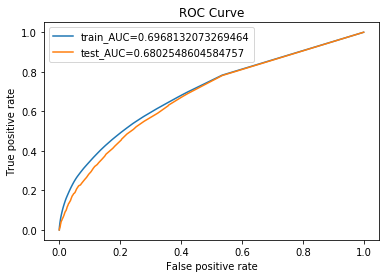

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

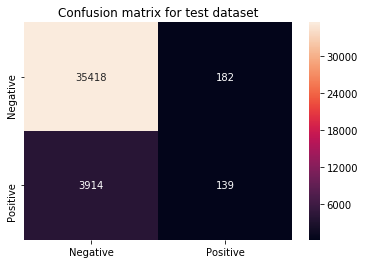

In [0]:
pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

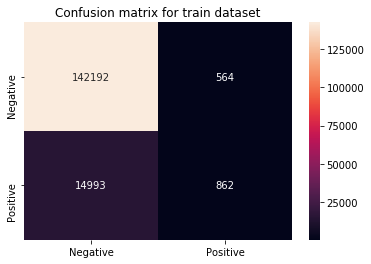

In [0]:
predictions=model.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.90      0.99      0.95     35600
positive_class       0.43      0.03      0.06      4053

      accuracy                           0.90     39653
     macro avg       0.67      0.51      0.50     39653
  weighted avg       0.85      0.90      0.86     39653



<h4> The AUC score is pretty bad if compared to both the logistic regression models but if the confusion matrix is compared to both the logistic regression models than it can be seen that this model performed better on negative datapoints and worse on positive datapoints.

<h4> 8.3.2 On the dataset with original and basic features </h4>

In [0]:
features = train_df_basic_f.drop(['ID_code','target'],axis=1)
features = features.drop([features.columns[0]], axis='columns')
target = train_df['target']
print(features.shape, target.shape)

(198264, 408) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 408) (158611,)
(39653, 408) (39653,)


<h4> FInding the suitable parameters for the model.

In [0]:
tuned_parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split':[5, 10, 100, 500]}


DT_model = DecisionTreeClassifier()
model = GridSearchCV(DT_model,tuned_parameters,
                     scoring='roc_auc',cv=2,n_jobs=-1)

model.fit(X_train, y_train)

print(model.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


<h4> Running the model and looking at the results.

In [0]:
model=DecisionTreeClassifier(max_depth=10, min_samples_split=500)

model.fit(X_train, y_train)
train_fpr, train_tpr, thresholds=roc_curve(y_train, model.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds=roc_curve(y_test, model.predict_proba(X_test)[:, 1])

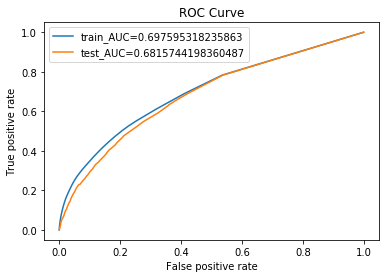

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

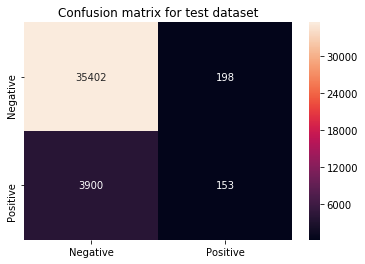

In [0]:
pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

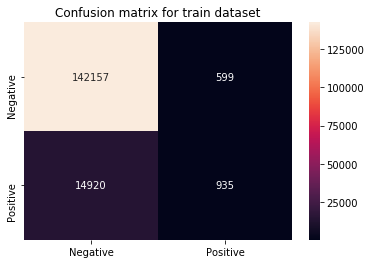

In [0]:
predictions=model.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.90      0.99      0.95     35600
positive_class       0.44      0.04      0.07      4053

      accuracy                           0.90     39653
     macro avg       0.67      0.52      0.51     39653
  weighted avg       0.85      0.90      0.86     39653



<h4> Here also the AUC result is worse if compared to both the logistic regression models but this model again performed better on negative than on positive datapoints.

<h4> 8.3.3. On the dataset with original and genetic features.

<h4> Preparing the dataset.

In [0]:
features = train_df_genetic_f.drop(['ID_code','target'],axis=1)
features = features.drop([features.columns[0]], axis='columns')
target = train_df['target']
print(features.shape, target.shape)

(198264, 400) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 400) (158611,)
(39653, 400) (39653,)


<h4> Finding the right hyperparameters for the model.

In [0]:
tuned_parameters = {'max_depth':[1, 5, 10, 50, 100, 500, 1000], 'min_samples_split':[5, 10, 100, 500]}


DT_model = DecisionTreeClassifier()
model = GridSearchCV(DT_model,tuned_parameters,
                     scoring='roc_auc',cv=2,n_jobs=-1)

model.fit(X_train, y_train)

print(model.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


<h4> Running the optimal model and comparing the results

In [0]:
model=DecisionTreeClassifier(max_depth=10, min_samples_split=500)

model.fit(X_train, y_train)
train_fpr, train_tpr, thresholds=roc_curve(y_train, model.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds=roc_curve(y_test, model.predict_proba(X_test)[:, 1])

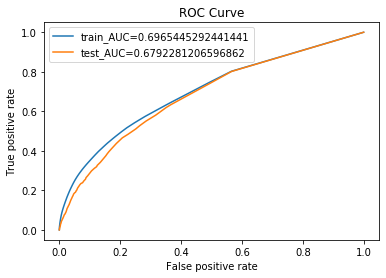

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

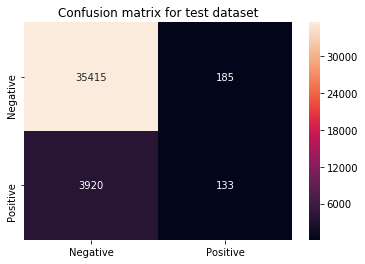

In [0]:
pred=model.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

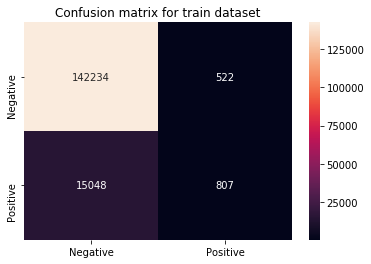

In [0]:
predictions=model.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.90      0.99      0.95     35600
positive_class       0.42      0.03      0.06      4053

      accuracy                           0.90     39653
     macro avg       0.66      0.51      0.50     39653
  weighted avg       0.85      0.90      0.85     39653



<h4> Once again if the AUC score is compared than it can be seen that it is quite bad but the model once and proved to be fruitful on negative datapoints if compared to both the logistic regression models than the positive datapoints

<h4> Comparing the AUC results of all the three decision tree models.

In [5]:
x = PrettyTable()
x.title = 'AUC results of all the three decision tree models.'
x.field_names = ['Dataset form', 'Test AUC score', 'Train AUC score']
x.add_row(['Only with original features', 0.68025, 0.69681])
x.add_row(['With original and basic features', 0.68157, 0.69759 ])
x.add_row(['With original and genetic features',0.67922, 0.69654])
print(x)

+-----------------------------------------------------------------------+
|           AUC results of all the three decision tree models.          |
+------------------------------------+----------------+-----------------+
|            Dataset form            | Test AUC score | Train AUC score |
+------------------------------------+----------------+-----------------+
|    Only with original features     |    0.68025     |     0.69681     |
|  With original and basic features  |    0.68157     |     0.69759     |
| With original and genetic features |    0.67922     |     0.69654     |
+------------------------------------+----------------+-----------------+


<h3> 8.4. Gaussian Naive Bayes

<h4> 8.4.1. On the original dataset with no added features.

<h4> Preparing the dataset.

In [0]:
features = train_df.drop(['ID_code','target'],axis=1)
target = train_df['target']
print(features.shape, target.shape)

(198264, 200) (198264,)


In [0]:
X_train, X_CV, y_train, y_CV=train_test_split(features, target, test_size=0.2, random_state=42)
X_CV, X_test, y_CV, y_test=train_test_split(X_CV, y_CV, test_size=0.5, random_state=42)
X_train=np.asarray(X_train)
X_CV=np.asarray(X_CV)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_CV=sc.transform(X_CV)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_CV.shape, y_CV.shape)
print(X_test.shape, y_test.shape)

(158611, 200) (158611,)
(19826, 200) (19826,)
(19827, 200) (19827,)


<h4> Finding the suitable parameters for the model.

In [0]:
tr_scores=[]
cv_scores=[]
smoothing=[10**-9, 10**-7, 10**-5, 10**-3, 10**-1, 1]
for s in tqdm(smoothing):
  gnb=GaussianNB(var_smoothing=s)
  gnb.fit(X_train, y_train)
  y_train_predict=gnb.predict_proba(X_train)[:,1]
  y_cv_predict=gnb.predict_proba(X_CV)[:,1]
  tr_scores.append(roc_auc_score(y_train, y_train_predict))
  cv_scores.append(roc_auc_score(y_CV, y_cv_predict))

100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


<h4> Running the optimal model and looking at the results

In [0]:
optimal=smoothing[cv_scores.index(max(cv_scores))]

In [0]:
gnb_optimal=GaussianNB(var_smoothing=optimal)

gnb_optimal.fit(X_train, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, gnb_optimal.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, gnb_optimal.predict_proba(X_test)[:, 1])

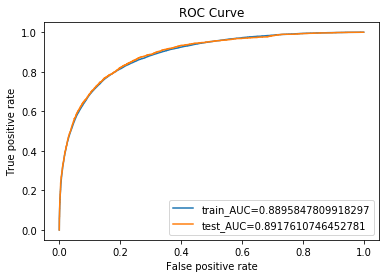

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

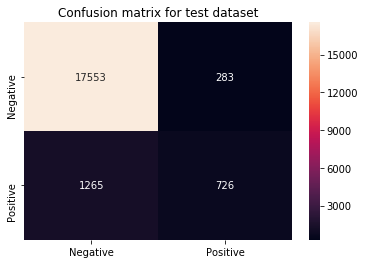

In [0]:
pred=gnb_optimal.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

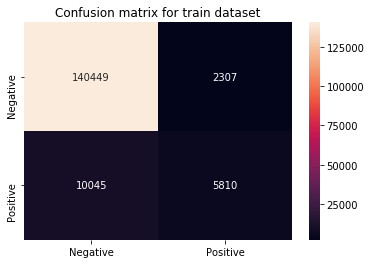

In [0]:
predictions=gnb_optimal.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.93      0.98      0.96     17836
positive_class       0.72      0.36      0.48      1991

      accuracy                           0.92     19827
     macro avg       0.83      0.67      0.72     19827
  weighted avg       0.91      0.92      0.91     19827



<h4> The AUC result is higher if compared to both the logistic regression model.

<h3> 8.4.2 On the dataset with original and basic features.

<h4> Preparing the dataset.

In [0]:
features = train_df_basic_f.drop(['ID_code','target'],axis=1)
features = features.drop([features.columns[0]], axis='columns')
target = train_df['target']
print(features.shape, target.shape)

(198264, 408) (198264,)


In [0]:
X_train, X_CV, y_train, y_CV=train_test_split(features, target, test_size=0.2, random_state=42)
X_CV, X_test, y_CV, y_test=train_test_split(X_CV, y_CV, test_size=0.5, random_state=42)
X_train=np.asarray(X_train)
X_CV=np.asarray(X_CV)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_CV=sc.transform(X_CV)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_CV.shape, y_CV.shape)
print(X_test.shape, y_test.shape)

(158611, 408) (158611,)
(19826, 408) (19826,)
(19827, 408) (19827,)


<h4> Finding the optimal parameters for the model.

In [0]:
tr_scores=[]
cv_scores=[]
smoothing=[10**-9, 10**-7, 10**-5, 10**-3, 10**-1, 1]
for s in tqdm(smoothing):
  gnb=GaussianNB(var_smoothing=s)
  gnb.fit(X_train, y_train)
  y_train_predict=gnb.predict_proba(X_train)[:,1]
  y_cv_predict=gnb.predict_proba(X_CV)[:,1]
  tr_scores.append(roc_auc_score(y_train, y_train_predict))
  cv_scores.append(roc_auc_score(y_CV, y_cv_predict))

100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


<h4> Running the suitable model and looking the results.

In [0]:
optimal=smoothing[cv_scores.index(max(cv_scores))]

In [0]:
gnb_optimal=GaussianNB(var_smoothing=optimal)

gnb_optimal.fit(X_train, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, gnb_optimal.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, gnb_optimal.predict_proba(X_test)[:, 1])

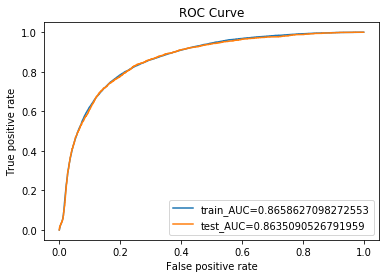

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

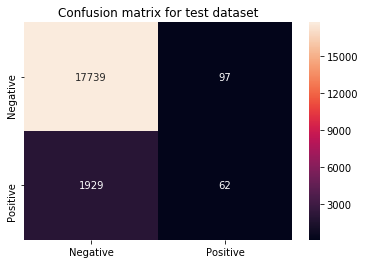

In [0]:
pred=gnb_optimal.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

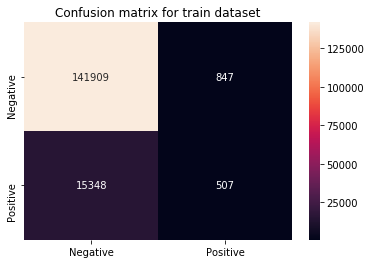

In [0]:
predictions=gnb_optimal.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.90      0.99      0.95     17836
positive_class       0.39      0.03      0.06      1991

      accuracy                           0.90     19827
     macro avg       0.65      0.51      0.50     19827
  weighted avg       0.85      0.90      0.86     19827



<h4> The AUC score deteriorated if compared to both the logistic regression models.

<h4> 8.4.3. On the dataset with original and genetic features.

<h4> Preparing the dataset.

In [0]:
features = train_df_genetic_f.drop(['ID_code','target'],axis=1)
features = features.drop([features.columns[0]], axis='columns')
target = train_df['target']
print(features.shape, target.shape)

(198264, 400) (198264,)


In [0]:
X_train, X_CV, y_train, y_CV=train_test_split(features, target, test_size=0.2, random_state=42)
X_CV, X_test, y_CV, y_test=train_test_split(X_CV, y_CV, test_size=0.5, random_state=42)
X_train=np.asarray(X_train)
X_CV=np.asarray(X_CV)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_CV=sc.transform(X_CV)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_CV.shape, y_CV.shape)
print(X_test.shape, y_test.shape)

(158611, 400) (158611,)
(19826, 400) (19826,)
(19827, 400) (19827,)


<h4> Finding the suitable hyperparameters for the model.

In [0]:
tr_scores=[]
cv_scores=[]
smoothing=[10**-9, 10**-7, 10**-5, 10**-3, 10**-1, 1]
for s in tqdm(smoothing):
  gnb=GaussianNB(var_smoothing=s)
  gnb.fit(X_train, y_train)
  y_train_predict=gnb.predict_proba(X_train)[:,1]
  y_cv_predict=gnb.predict_proba(X_CV)[:,1]
  tr_scores.append(roc_auc_score(y_train, y_train_predict))
  cv_scores.append(roc_auc_score(y_CV, y_cv_predict))

100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


<h4> Running the optimal model and looking at the results.

In [0]:
optimal=smoothing[cv_scores.index(max(cv_scores))]

In [0]:
gnb_optimal=GaussianNB(var_smoothing=optimal)

gnb_optimal.fit(X_train, y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, gnb_optimal.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, gnb_optimal.predict_proba(X_test)[:, 1])

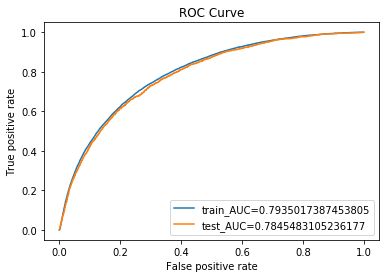

In [0]:
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

Text(0.5, 1, 'Confusion matrix for test dataset')

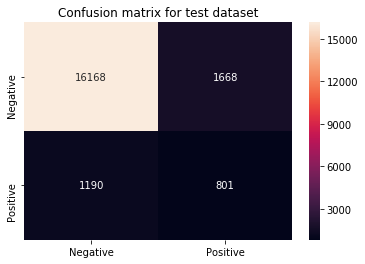

In [0]:
pred=gnb_optimal.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

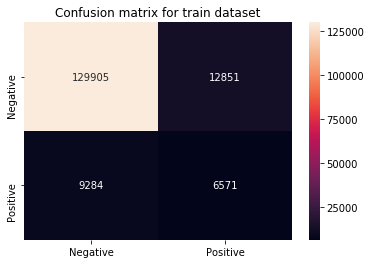

In [0]:
predictions=gnb_optimal.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

In [0]:
target_names=['negative_class', 'positive_class']
print(classification_report(y_test, pred, target_names=target_names))

                precision    recall  f1-score   support

negative_class       0.93      0.91      0.92     17836
positive_class       0.32      0.40      0.36      1991

      accuracy                           0.86     19827
     macro avg       0.63      0.65      0.64     19827
  weighted avg       0.87      0.86      0.86     19827



<h4> Once again it can be seen that the model performance has been deteriorated, thus it can be said that Gaussian Naive Bayes worked best with the original dataset with no added features.

<h4> Comparing the results of all the three Gaussian Naive Bayes models.

In [6]:
x = PrettyTable()
x.title = 'Results of all the three Gaussian Naive Bayes models.'
x.field_names = ['Dataset form', 'Test AUC score', 'Train AUC score']
x.add_row(['Only with original features', 0.89176, 0.88958])
x.add_row(['With original and basic features', 0.86350, 0.86586 ])
x.add_row(['With original and genetic features',0.78454, 0.79350])
print(x)

+-----------------------------------------------------------------------+
|         Results of all the three Gaussian Naive Bayes models.         |
+------------------------------------+----------------+-----------------+
|            Dataset form            | Test AUC score | Train AUC score |
+------------------------------------+----------------+-----------------+
|    Only with original features     |    0.89176     |     0.88958     |
|  With original and basic features  |     0.8635     |     0.86586     |
| With original and genetic features |    0.78454     |      0.7935     |
+------------------------------------+----------------+-----------------+


<h3> 8.5. Random Forest Model without Hyperparameter tuning

<h4> 8.5.1. On the original dataset with no added features.

<h4> Preparing the dataset.

In [0]:
features = train_df.drop(['ID_code','target'],axis=1)
target = train_df['target']
print(features.shape, target.shape)

(198264, 200) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 200) (158611,)
(39653, 200) (39653,)


<h4> Using only 50 estimators to fit the model and looking the results.

In [0]:
r_cfl=RandomForestClassifier(n_estimators=50,n_jobs=-1)
r_cfl.fit(X_train,y_train)
cal_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
cal_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=None,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                                                             min_weight_fraction_leaf=0.0,
                                                             n_estimators=50,
                 

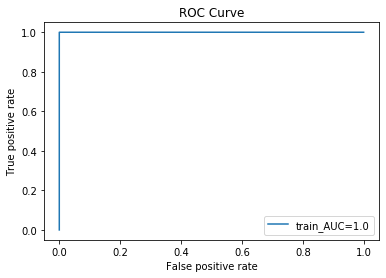

In [0]:
train_fpr, train_tpr, thresholds=roc_curve(y_train, cal_clf.predict_proba(X_train)[:, 1])
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

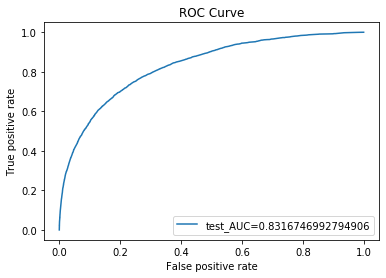

In [0]:
test_fpr, test_tpr, thresholds=roc_curve(y_test, cal_clf.predict_proba(X_test)[:, 1])
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

In [0]:
predict_y = cal_clf.predict_proba(X_train)
print('Training_ROC Score is :',roc_auc_score(y_train,predict_y[:,1]))
predict_y = cal_clf.predict_proba(X_test)
print('Testing_ROC Score is :',roc_auc_score(y_test,predict_y[:,1]))

Training_ROC Score is : 1.0
Testing_ROC Score is : 0.8316746992794906


Text(0.5, 1, 'Confusion matrix for test dataset')

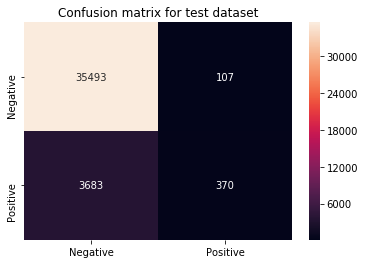

In [0]:
pred=cal_clf.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

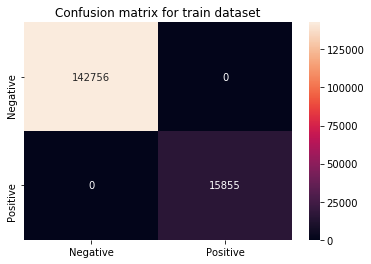

In [0]:
predictions=cal_clf.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

<h4> As from the above results, it can clearly be seen that this simple random forest model is overfitting there is a huge difference between the training and testing ROC AUC Score and also in the confusion matrix, we can see in the training matrix there is no false positive's and false negative's but in testing matrix we can see large numbers of false positives. Thus deciding not going further with Random Forest model with other forms of dataset as the original dataset with no added features is overfitting the data.

<b> As it can be seen from the results of Logistic regression, Decision Tree and Gaussian Naive Bayes from the above cells that dataset with genetic features does not provide great improvement in AUC scores and thus running XGBoost on only two forms of dataset, they are:-

- Dataset with only original features.
- Dataset with original and basic features.

<h3> 8.6. XGBoost Model with Hyperparameter tuning

<h4> 8.6.1 On original dataset with no added features.

<h4> Preparing the dataset.

In [0]:
features = train_df.drop(['ID_code','target'],axis=1)
target = train_df['target']
print(features.shape, target.shape)

(198264, 200) (198264,)


In [0]:
X_train, X_test, y_train, y_test=train_test_split(features, target, test_size=0.2, random_state=42)
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 200) (158611,)
(39653, 200) (39653,)


<h4> Finding the best hyperparameters for the model.

In [0]:
model = XGBClassifier(
    eval_metric=["auc"]
)

param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

scoring = {
    'AUC': 'roc_auc', 
}

# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
    verbose=1
)

grid.fit(X_train,y_train)
best_clf=grid.best_estimator_

In [0]:
best_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric=['auc'],
              gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbose=1, verbosity=1)

<h4> Fitting the optimal model and looking at the results.

In [0]:
best_clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, eval_metric=['auc'], gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, n_estimators=400, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbose=1)
best_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric=['auc'],
              gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbose=1, verbosity=1)

In [0]:
cal_clf = CalibratedClassifierCV(best_clf, method="sigmoid")
cal_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.8,
                                                    eval_metric=['auc'],
                                                    gamma=0.1,
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=4,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=400, n_jobs=-1,
                                                    nthread=None,
                

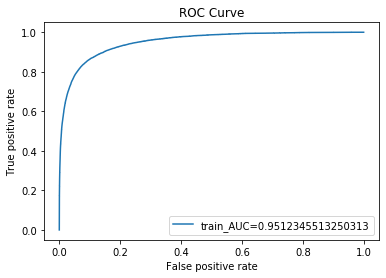

In [0]:
train_fpr, train_tpr, thresholds=roc_curve(y_train, cal_clf.predict_proba(X_train)[:, 1])
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

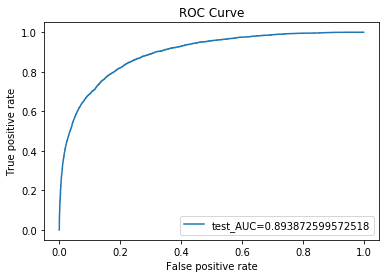

In [0]:
test_fpr, test_tpr, thresholds=roc_curve(y_test, cal_clf.predict_proba(X_test)[:, 1])
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

In [0]:
predict_y = cal_clf.predict_proba(X_train)
print('Training_ROC Score is :',roc_auc_score(y_train,predict_y[:,1]))
predict_y = cal_clf.predict_proba(X_test)
print('Testing_ROC Score is :',roc_auc_score(y_test,predict_y[:,1]))

Training_ROC Score is : 0.9512345513250313
Testing_ROC Score is : 0.893872599572518


Text(0.5, 1, 'Confusion matrix for test dataset')

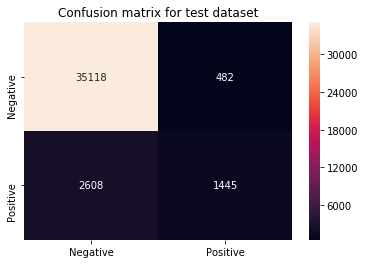

In [0]:
pred=cal_clf.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

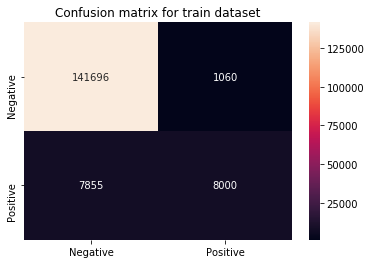

In [0]:
predictions=cal_clf.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

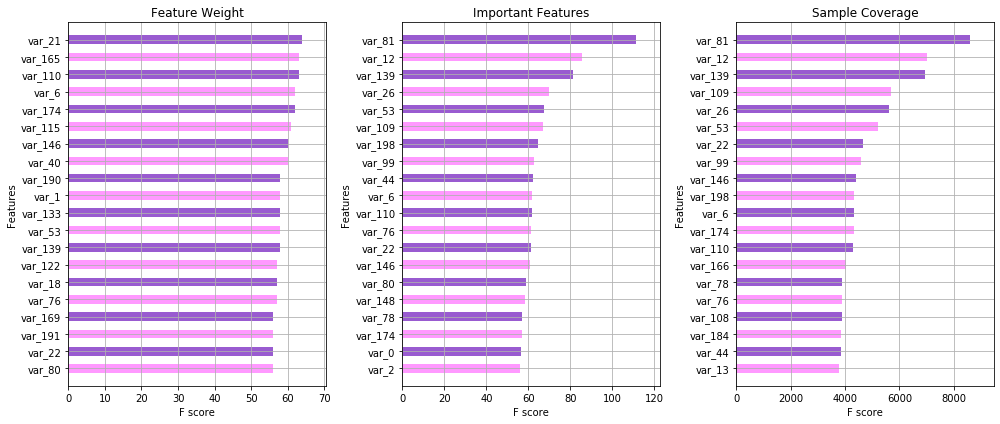

In [0]:
#Taken from:- https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101
import xgboost as xgb
# store the winning model in a new variable
xgc = best_clf
# saving the feature names to the model
xgc.get_booster().feature_names = list(features.columns)
# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(14,6))
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgc,
    max_num_features=20,
    importance_type='gain',
    title='Important Features',
    show_values=False,
    height=0.5,
    ax=ax[1],
    color=['#FF99FF','#995BD0']
)
# plot importances with feature weight
xgb.plot_importance(
    booster=xgc, 
    max_num_features=20,
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
    color=['#FF99FF','#995BD0']
)

# plot importances with sample coverage
xgb.plot_importance(
    xgc,
    max_num_features=20,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2],
    color=['#FF99FF','#995BD0']
)
plt.tight_layout()
plt.show()

<h4> XGBoost model is doing pretty well as compared to the random forest model this is all because of the hyperparameter tuning and cross-validation, now it can be seen that there is difference between training and testing ROC AUC score as it has been decreased from that of Random forest model. In the testing confusion matrix, it can be seen that XGBoost has decreased the false positive's but still there is a chance of improvement as there is no feature engineering involved. The top 20 important features from XGBoost model has been plotted.  

<h4> 8.6.2. On the dataset with original and basic features in addition with class weight balance

<h4> Preparing the dataset.

In [0]:
features = train_df_basic_f.drop(['ID_code','target'],axis=1)
features = features.drop([features.columns[0]], axis='columns')
target = train_df['target']
print(features.shape, target.shape)

(198264, 408) (198264,)


In [0]:
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.20,stratify=target)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(158611, 408) (158611,)
(39653, 408) (39653,)


<h4> Preparing class weights.

In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [0]:
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]

<h4> Finding the right hyperparameter for the model

In [0]:
model = XGBClassifier(
    eval_metric=["auc"]
)

param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}

scoring = {
    'AUC': 'roc_auc', 
}

# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds)
# create the grid search object
n_iter=50
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
    verbose=1
)

best_model = grid.fit(X_train,y_train)
best_clf=grid.best_estimator_

In [0]:
best_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric=['auc'],
              gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

<h4> Fitting the optimal model and looking at the results.

In [0]:
best_clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=0.8, eval_metric=['auc'], gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1,n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8)
best_clf.fit(X_train,y_train,sample_weight=w_array)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric=['auc'],
              gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [0]:
cal_clf = CalibratedClassifierCV(best_clf, method="sigmoid")
cal_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.8,
                                                    eval_metric=['auc'],
                                                    gamma=0.1,
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=4,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=400, n_jobs=1,
                                                    nthread=None,
                 

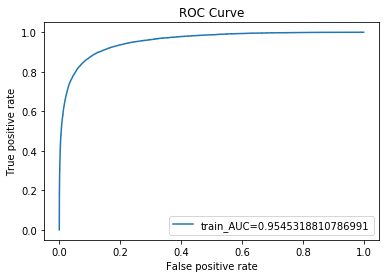

In [0]:
train_fpr, train_tpr, thresholds=roc_curve(y_train, cal_clf.predict_proba(X_train)[:, 1])
plt.plot(train_fpr, train_tpr, label='train_AUC='+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

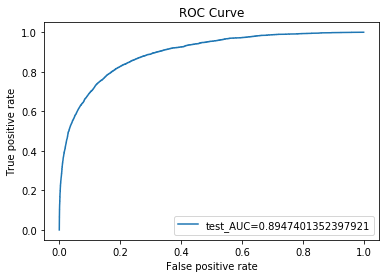

In [0]:
test_fpr, test_tpr, thresholds=roc_curve(y_test, cal_clf.predict_proba(X_test)[:, 1])
plt.plot(test_fpr, test_tpr, label='test_AUC='+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

In [0]:
predict_y = cal_clf.predict_proba(X_train)
print('Training_ROC Score is :',roc_auc_score(y_train,predict_y[:,1]))
predict_y = cal_clf.predict_proba(X_test)
print('Testing_ROC Score is :',roc_auc_score(y_test,predict_y[:,1]))

Training_ROC Score is : 0.9545318810786991
Testing_ROC Score is : 0.8947401352397921


Text(0.5, 1, 'Confusion matrix for test dataset')

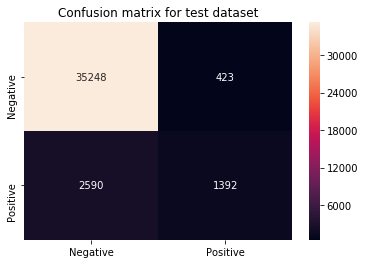

In [0]:
pred=cal_clf.predict(X_test)
conf_matrix=confusion_matrix(y_test, pred)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

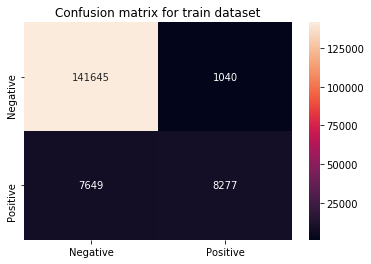

In [0]:
predictions=cal_clf.predict(X_train)
conf_matrix=confusion_matrix(y_train, predictions)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

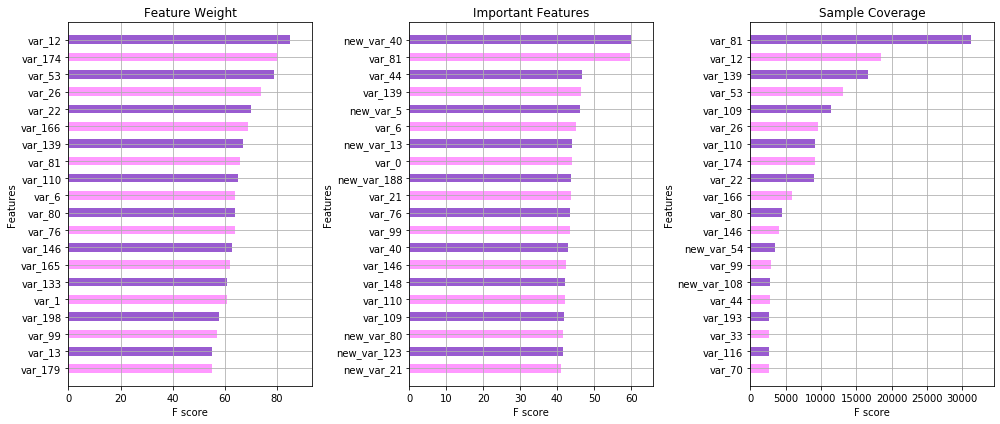

In [0]:
#Taken from:- https://towardsdatascience.com/running-xgboost-on-google-colab-free-gpu-a-case-study-841c90fef101
import xgboost as xgb
# store the winning model in a new variable
xgc = best_clf
# saving the feature names to the model
xgc.get_booster().feature_names = list(features.columns)
# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(14,6))
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgc,
    max_num_features=20,
    importance_type='gain',
    title='Important Features',
    show_values=False,
    height=0.5,
    ax=ax[1],
    color=['#FF99FF','#995BD0']
)
# plot importances with feature weight
xgb.plot_importance(
    booster=xgc, 
    max_num_features=20,
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
    color=['#FF99FF','#995BD0']
)

# plot importances with sample coverage
xgb.plot_importance(
    xgc,
    max_num_features=20,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2],
    color=['#FF99FF','#995BD0']
)
plt.tight_layout()
plt.show()

<h4> As it can be seen that there is a slight increase in testing ROC AUC score and also there is not much difference between training and testing ROC AUC Score. From the important feature plot, it can be seen that the new basic features are contributing pretty well in the model.

<h4> Comparing the results of the two XGBoost models.

In [8]:
x = PrettyTable()
x.title = 'AUC results of the two XGBoost models.'
x.field_names = ['Dataset form', 'Test AUC score', 'Train AUC score']
x.add_row(['Only with original features', 0.89387, 0.95123])
x.add_row(['With original and basic features', 0.89474, 0.95453 ])
print(x)

+---------------------------------------------------------------------+
|                AUC results of the two XGBoost models.               |
+----------------------------------+----------------+-----------------+
|           Dataset form           | Test AUC score | Train AUC score |
+----------------------------------+----------------+-----------------+
|   Only with original features    |    0.89387     |     0.95123     |
| With original and basic features |    0.89474     |     0.95453     |
+----------------------------------+----------------+-----------------+


<h3> 8.7. LightGBM Model with Bayesian Optimization and Data Augmentation

<b> Note:- Reference of this section has been taken from https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment 

<h4> 8.7.1 On the dataset with original and basic features.

In [0]:
features = train_df_basic_f.drop(['ID_code','target'],axis=1)
features = features.drop([features.columns[0]], axis='columns')
target = train_df['target']
print(features.shape, target.shape)

(198264, 408) (198264,)


In [0]:
X_train_cv,X_test,y_train_cv,y_test=train_test_split(features,target,test_size=0.20,stratify=target)
X_train_cv.shape, X_test.shape

((158611, 408), (39653, 408))

In [0]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [0]:
# best parameter after bayesian opitmization
random_state = 42
np.random.seed(random_state)

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 1.0,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': -1
}

In [0]:
num_folds = 11
features = [i for i in features.columns ]

folds = KFold(n_splits=num_folds, random_state=random_state)
oof = np.zeros(len(X_train_cv))
getVal = np.zeros(len(X_train_cv))
predictions = np.zeros(len(y_train_cv))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_cv.values, y_train_cv.values)):
    
    X_train, y_train = X_train_cv.iloc[trn_idx][features], y_train_cv.iloc[trn_idx]
    X_valid, y_valid = X_train_cv.iloc[val_idx][features], y_train_cv.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(X_train_cv.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(X_train_cv.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    #predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(y_train_cv, oof)))

Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.927187	valid_1's auc: 0.892344
[10000]	training's auc: 0.943236	valid_1's auc: 0.89415
Early stopping, best iteration is:
[8056]	training's auc: 0.937726	valid_1's auc: 0.894577
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.926921	valid_1's auc: 0.894885
[10000]	training's auc: 0.943189	valid_1's auc: 0.897834
[15000]	training's auc: 0.955871	valid_1's auc: 0.896969
Early stopping, best iteration is:
[11179]	training's auc: 0.946399	valid_1's auc: 0.897956
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.927361	valid_1's auc: 0.897057
[10000]	training's auc: 0.943434	valid_1's auc: 0.90008
Early stopping, best iteration is:
[10935]	training's auc: 0.945939	valid_1's auc: 0.900367
Fold idx:4
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.927834

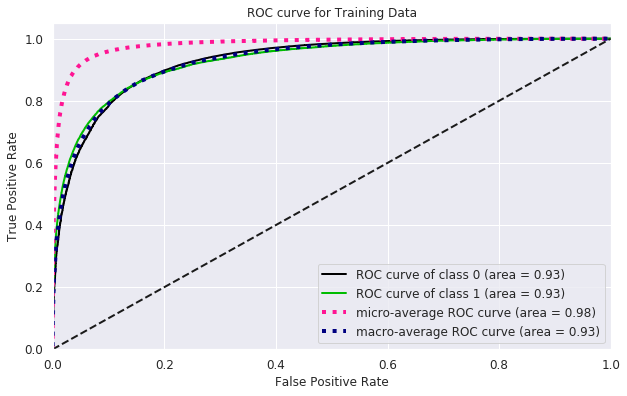

In [0]:
sns.set(rc={'figure.figsize':(10,6)})
predict_y = clf.predict(X_train_cv)
predict_y_prob=[[abs(1-i),i] for i in predict_y]
skplt.metrics.plot_roc_curve(y_train_cv, predict_y_prob)
plt.title('ROC curve for Training Data')
plt.show()

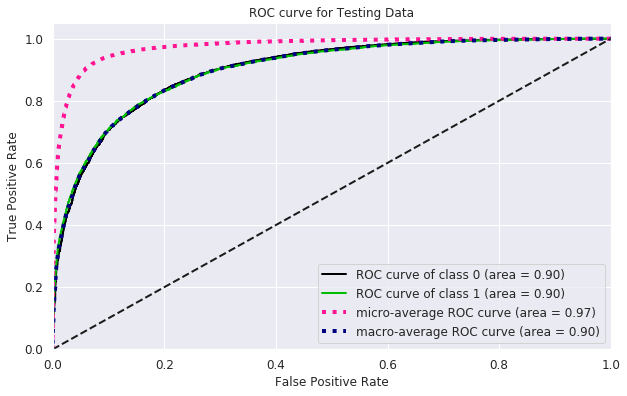

In [0]:
predict_y = clf.predict(X_test)
predict_y_prob=[[abs(1-i),i] for i in predict_y]
skplt.metrics.plot_roc_curve(y_test, predict_y_prob)
plt.title('ROC curve for Testing Data')
plt.show()

In [0]:
predict_y = clf.predict(X_train_cv)
print('Training_ROC Score is :',roc_auc_score(y_train_cv,predict_y))
predict_y = clf.predict(X_test)
print('Testing_ROC Score is :',roc_auc_score(y_test,predict_y))

Training_ROC Score is : 0.9295086856819318
Testing_ROC Score is : 0.899835028985316


Text(0.5, 1, 'Confusion matrix for test dataset')

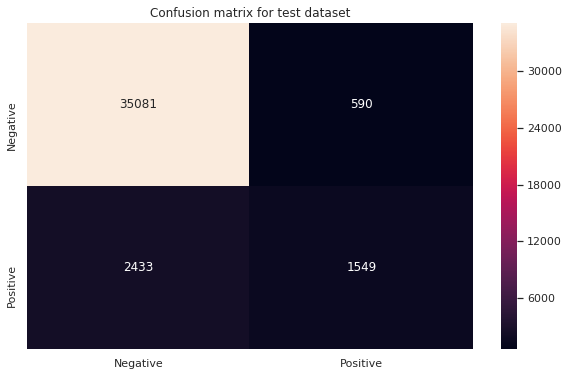

In [0]:
pred_test=clf.predict(X_test)
pred_test_v=[1 if i>0.5 else 0 for i in pred_test]
conf_matrix=confusion_matrix(y_test, pred_test_v)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for test dataset")

Text(0.5, 1, 'Confusion matrix for train dataset')

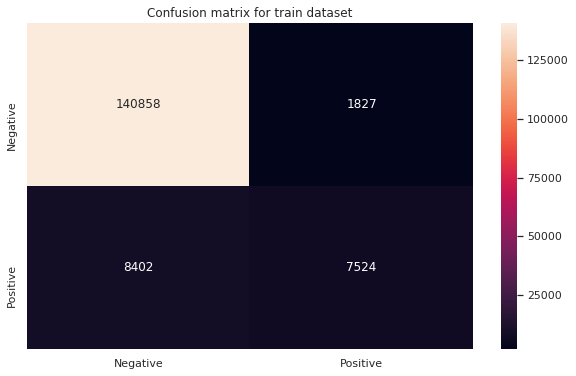

In [0]:
pred_train=clf.predict(X_train_cv)
pred_train_v=[1 if i>0.5 else 0 for i in pred_train]
conf_matrix=confusion_matrix(y_train_cv, pred_train_v)
confusion_matrix_df=pd.DataFrame(conf_matrix, ["Negative", "Positive"], ["Negative", "Positive"])
sns.heatmap(confusion_matrix_df, annot=True, fmt="g")
plt.title("Confusion matrix for train dataset")

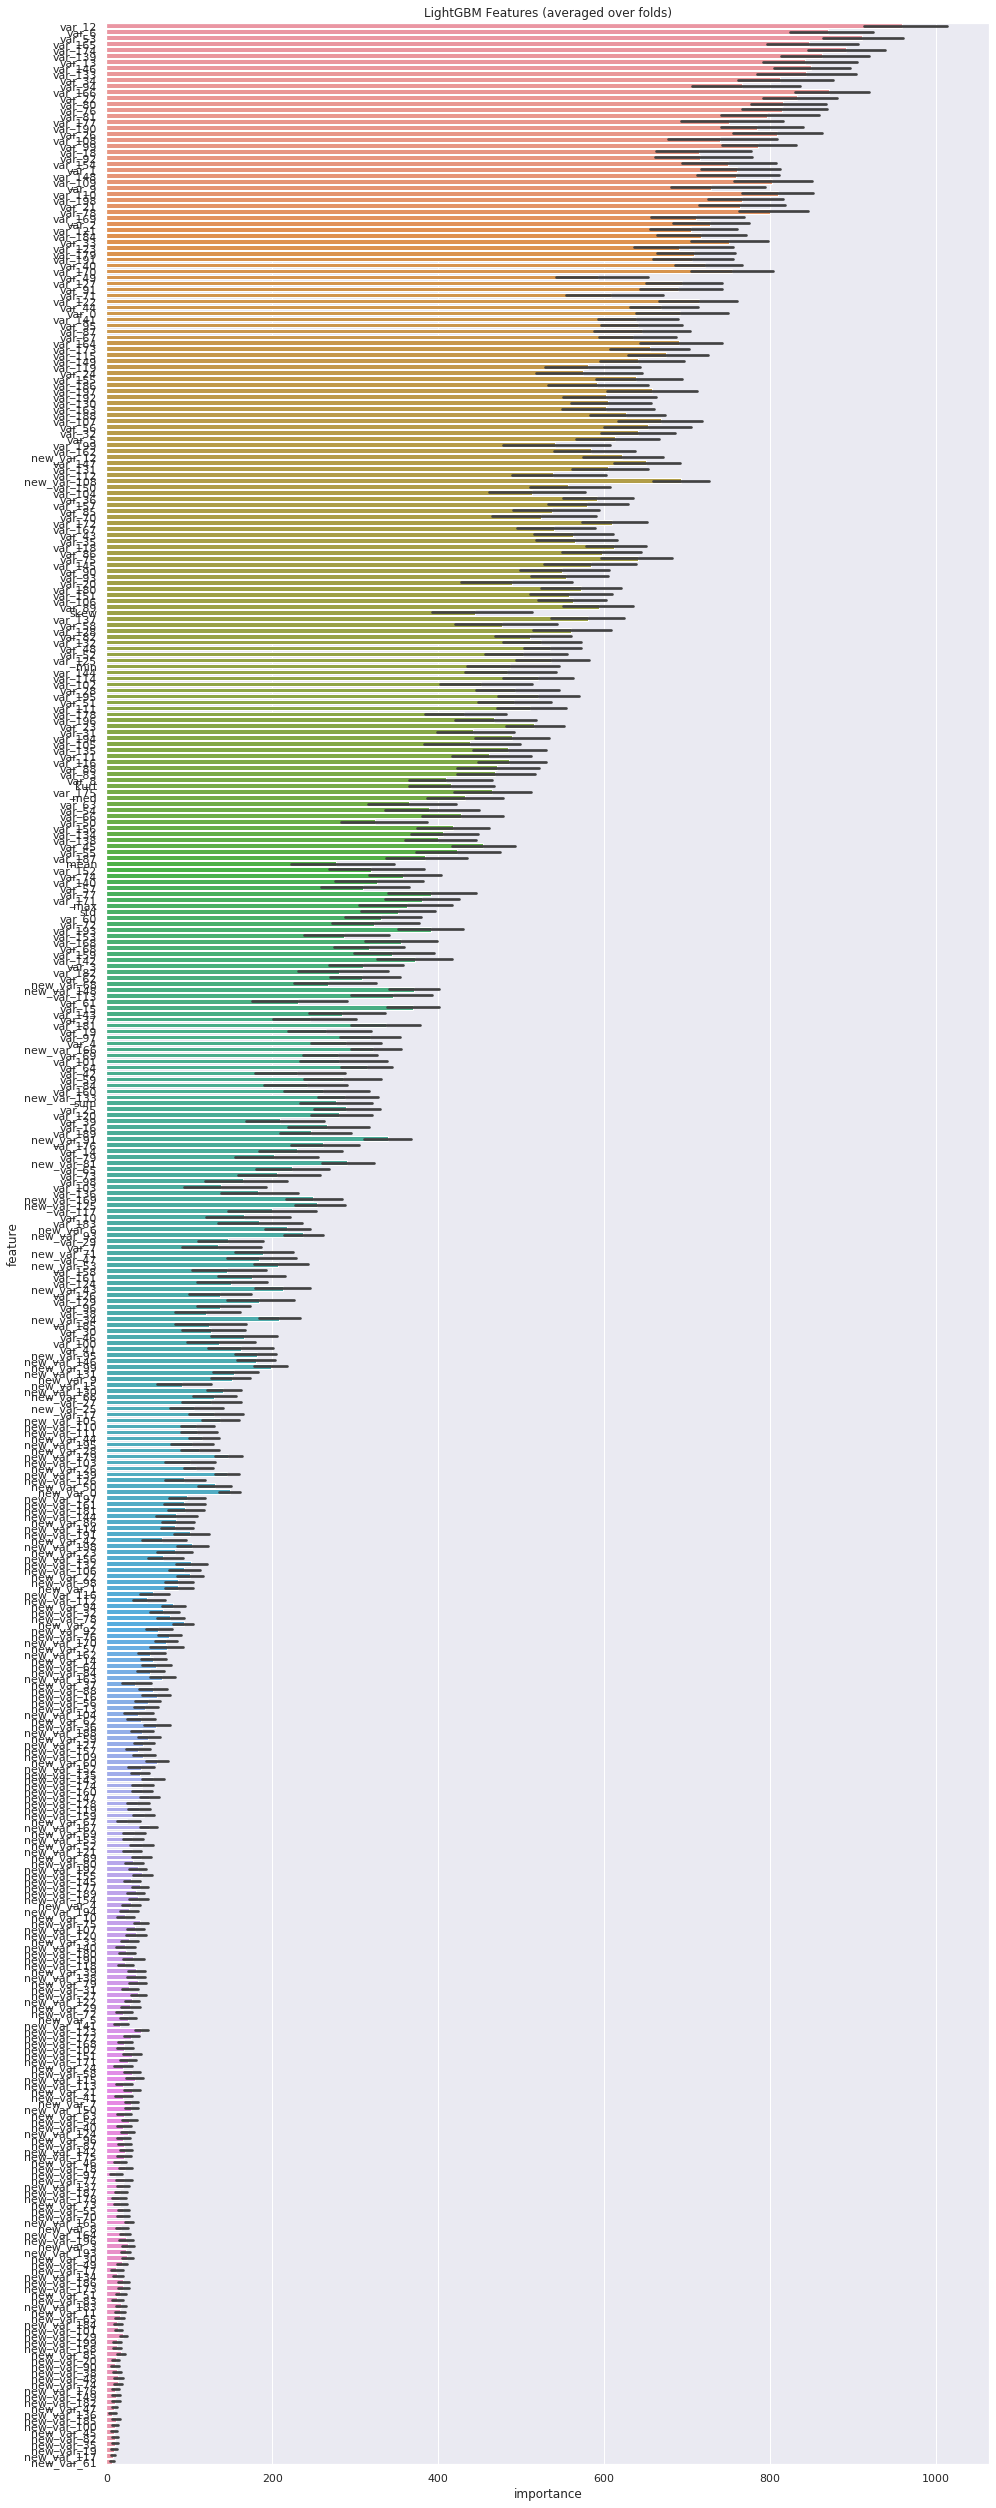

In [0]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,35))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<h4> By using LightGBM training and test ROC Scores are very close to each other which shows this model is not overfitting that much and also number of True Positives are highest in LightGBM model which is very good.

<h3> 8.8. Picking the best machine learning model based on test AUC scores from each of the seven methods that were implemented in the above section and comparing the results.

In [18]:
x = PrettyTable()
x.title = 'Comparing the test AUC results of best machine learning model from each of the seven methods.'
x.field_names = ['Sr No.', 'Method', 'Dataset form', 'Test AUC score']
x.add_row([1, 'Logistic Regression(no class balance)', 'With original and basic features', 0.87229])
x.add_row([2, 'Logistic Regression(with class balance)', 'With original and basic features', 0.8718])
x.add_row([3, 'Decision Tree', 'With original and basic features', 0.68157])
x.add_row([4, 'Gaussian Naive Bayes', 'Only with original features', 0.89176])
x.add_row([5, 'Random Forest', 'Only with original features', 0.83167])
x.add_row([6, 'XGBoost', 'With original and basic features', 0.89474])
x.add_row([7, 'LightGBM', 'With original and basic features', 0.89983])

print(x)

+------------------------------------------------------------------------------------------------------+
|    Comparing the test AUC results of best machine learning model from each of the seven methods.     |
+--------+-----------------------------------------+----------------------------------+----------------+
| Sr No. |                  Method                 |           Dataset form           | Test AUC score |
+--------+-----------------------------------------+----------------------------------+----------------+
|   1    |  Logistic Regression(no class balance)  | With original and basic features |    0.87229     |
|   2    | Logistic Regression(with class balance) | With original and basic features |     0.8718     |
|   3    |              Decision Tree              | With original and basic features |    0.68157     |
|   4    |           Gaussian Naive Bayes          |   Only with original features    |    0.89176     |
|   5    |              Random Forest              |   

<h1> 9. Conclusion

* In this case study an anonymized dataset of 200,000 data points with 202 features in which 200 features were numerical was provided to us.
* From EDA it became clear that the data is highly imbalanced, there is no missing value in data, there are very small no. of outliers, there is very low correlation between each features.
* In feature engineering section we devised new features by looking the results obtained from the EDA section and using symbolic regression with the help of python's external library known as 'gplearn'
* After feature engineering the dataset was given three forms, one with only original features, other with basic features which were obtained by using the results of EDA section and last one was with original features with genetic features which was devised using 'gplearn'.
* These three forms of dataset were tested on 4 machine learning models and by analysing the results of these four models it was concluded that genetic features don't help much and thus were dropped from further analysis.
* By analysing the results of the seven models it can be stated that the features which were devised using EDA results were very fruitful because when the best results of the seven models are analysed it can be seen basic features were fruitful in five of them.
* The best result came from the LightGBM Model which shows the power of state of the art bayesian optimization and data augmentation techniques.
* Altough Gaussian Naive Bayes with only original features obtained almost the same result of LightGBM.
* The best train and test AUC scores were 0.929 and 0.899.